# Exploration of expression data for Tabula Sapiens

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [1]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2
import scanpy as sc
from scipy.stats import norm

## 1.2 Load Tabula Sapiens data

In [2]:
#load adata for Tabula Sapiens
all_cells_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

# 2. Processing function to create subset count matrices

In [2]:
def processing(adata):
    
    """
    This function creates a dense pandas dataframe of counts from the subset Tabula Sapiens adata object. The dataframe has 
    the dimensions cell x gene where the column axis is labelled by ensemblid and the cell axis also has tissue and cell type 
    column annotations.
    
    Input:
        adata (AnnData object): adata object for counts matrix to be generated from
        
    Output:
        counts_df (pandas dataframe): dense dataframe of the counts for each cell-gene pair annotated by the cell type and 
        tissue
    """
    
    #transform sparse matrix into pandas dataframe
    counts_df = pd.DataFrame.sparse.from_spmatrix(adata.X)
    
    #exponentiate counts so comparable to TPM (CPM counts)
    counts_df = np.expm1(counts_df)
    
    #convert sparse array columns into dense array columns
    counts_df = counts_df.sparse.to_dense()
    
    #set ensemblid as gene (column) axis
    counts_df = counts_df.set_axis(adata.var.index.values, axis = 1)
    
    
    counts_df.insert(0, 'cell_type', adata.obs['cell_ontology_class'].values)
    counts_df.insert(0, 'tissue', adata.obs['tissue_ontology_term_id'].values)
    
    return counts_df

# 3. Whole pancreas?
## 3.1 Read in total pancreas dataset (see 8.1.1 Comparison with Bulk notebook)

In [46]:
total_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

In [4]:
print(f'The whole pancreas has {len(total_pancreas)} cells.')

The whole pancreas has 13497 cells.


## 3.2 Insulin expression across cell types

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

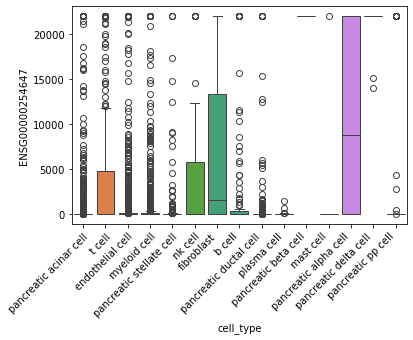

In [49]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = total_pancreas, x = 'cell_type', y = 'ENSG00000254647', hue = 'cell_type')

Most cell types don't have enough information to produce boxplots for insulin expression perhaps because the amount of zero counts in the data overwhelms the other data points.

**Remove zero expression data points**

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

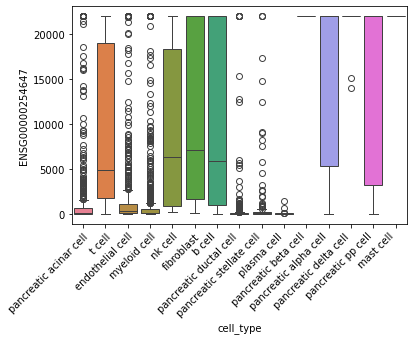

In [50]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = total_pancreas[total_pancreas['ENSG00000254647'] > 0], x = 'cell_type', y = 'ENSG00000254647', 
            hue = 'cell_type')

Removing the zero counts enables us to see better the distribution of non-zero expression values across the cell types which previously we could not.

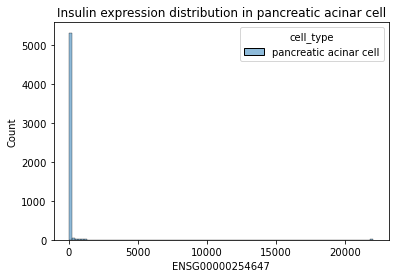

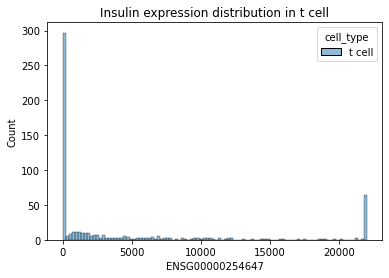

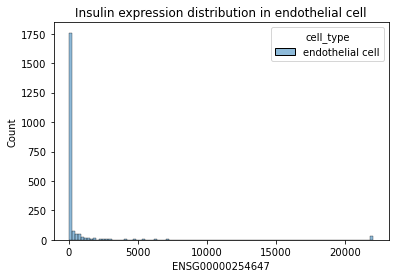

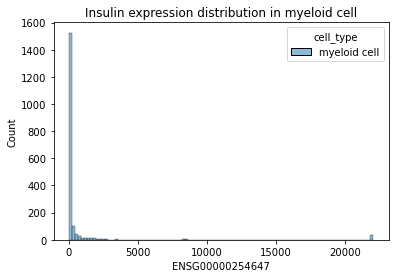

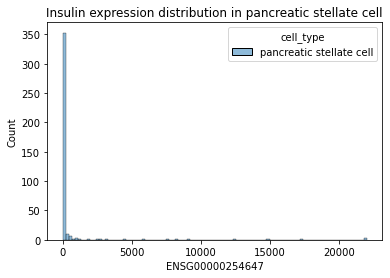

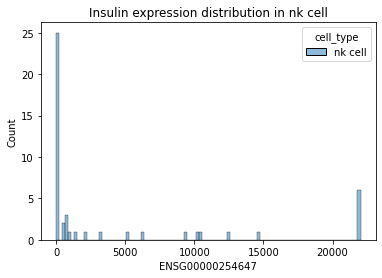

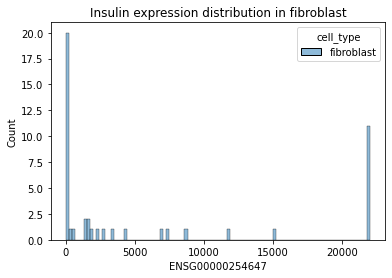

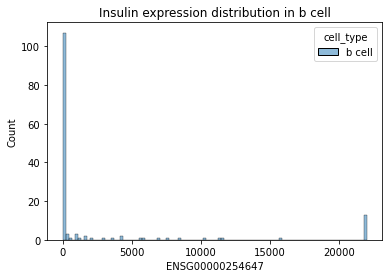

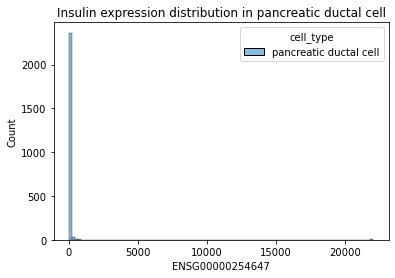

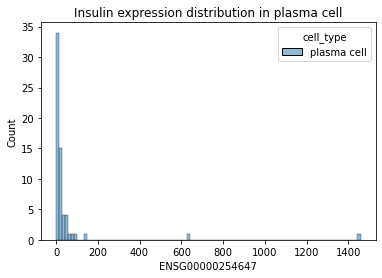

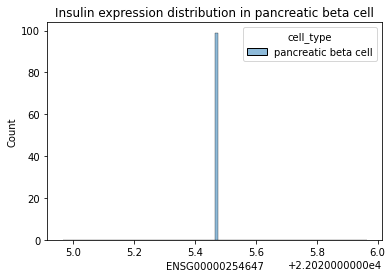

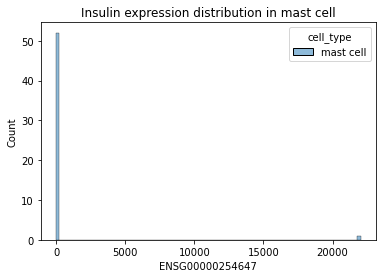

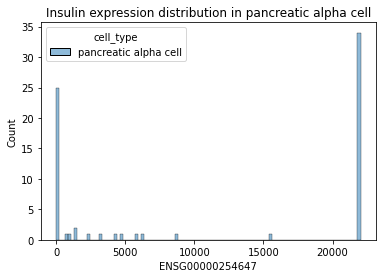

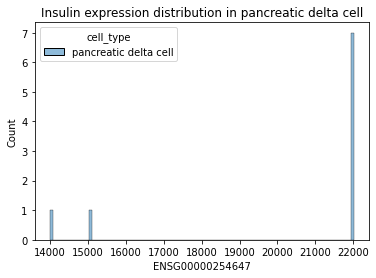

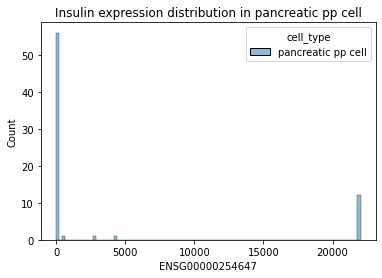

In [53]:
for i in total_pancreas.cell_type.unique():
    ax = sns.histplot(data = total_pancreas[total_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 100)
    plt.title(f'Insulin expression distribution in {i}')
    plt.show()

**Removing the zero count expressions**

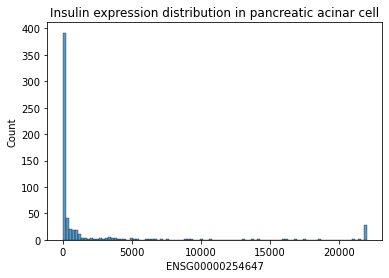

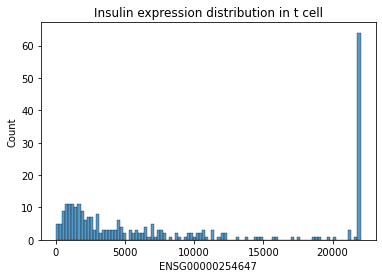

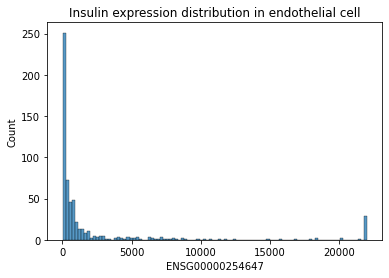

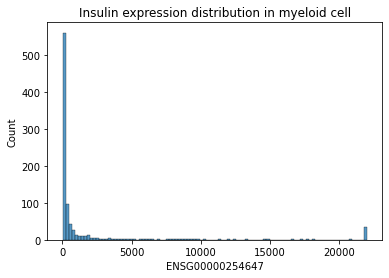

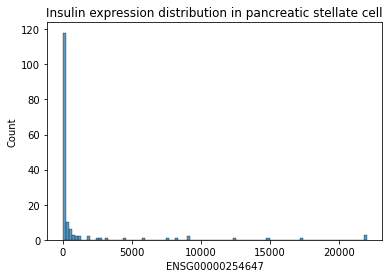

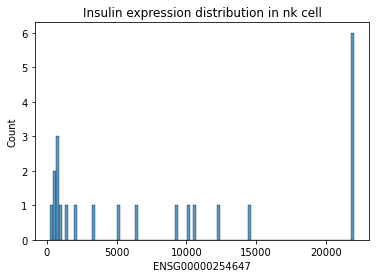

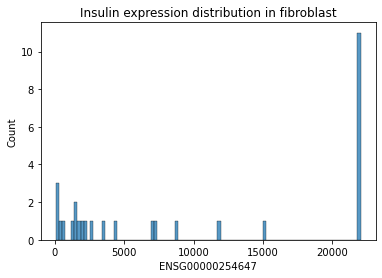

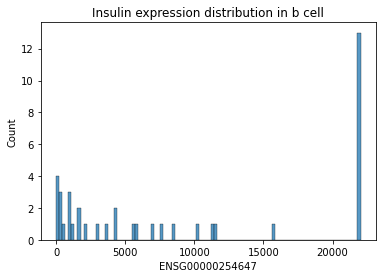

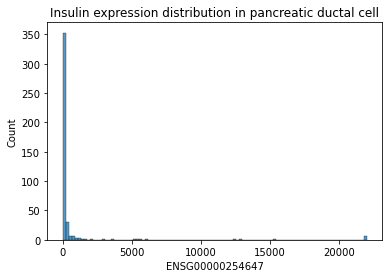

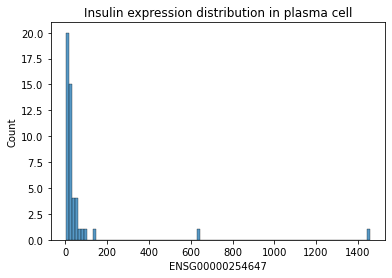

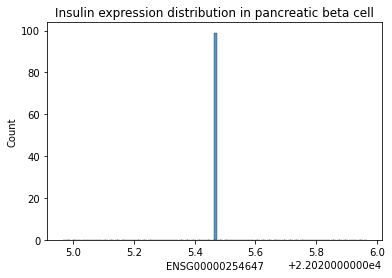

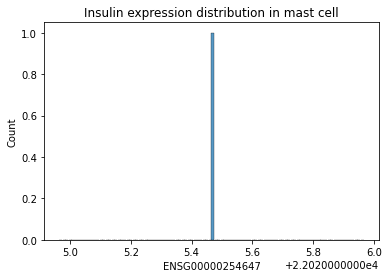

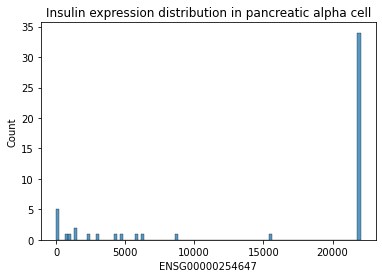

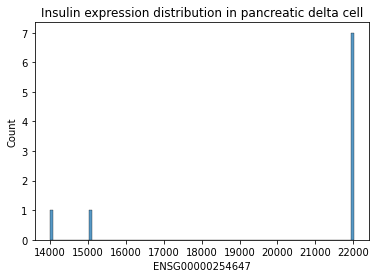

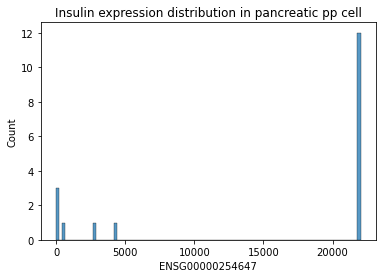

In [20]:
non_zero_filtered = total_pancreas[total_pancreas['ENSG00000254647'] > 0]

for i in total_pancreas.cell_type.unique():
    ax = sns.histplot(data = non_zero_filtered[non_zero_filtered.cell_type == i], x = 'ENSG00000254647', bins = 100)
    plt.title(f'Insulin expression distribution in {i}')
    plt.show()

Getting rid of the zero counts makes cell types like nk cells, fibroblasts and b cells appear to have a population of some cells with a high expression of insulin which is not expected as the gene is almost exclusively expressed in pancreatic beta cells.

Should we consider an expression threshold minimum before considering it as expressed? The pancreatic beta cells have 100 cells with roughly the same expression of ~22,000, this number of cells expressing the transcript is higher than any other cell type but we see this value also in other pancreatic islet of langerhans cell types but in a smaller number of cells.

In [24]:
#read in median counts data for pancreatic cells
median_pancreas = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')

In [26]:
pd.DataFrame(median_pancreas['ENSG00000254647'])

ENSG00000254647
cell_type                                
b cell                           0.000000
endothelial cell                 0.000000
fibroblast                    1506.253906
mast cell                        0.000000
myeloid cell                     0.000000
nk cell                          0.000000
pancreatic acinar cell           0.000000
pancreatic alpha cell         8804.474609
pancreatic beta cell         22025.464844
pancreatic delta cell        22025.464844
pancreatic ductal cell           0.000000
pancreatic pp cell               0.000000
pancreatic stellate cell         0.000000
plasma cell                      7.536572
t cell                           0.000000

These median values compared to the expression distributions show that the cell types with a limited number of cells annotated as the cell type show that this is where the contradictory expression median values appear to be coming from. It is a result of not enough cells being sampled for the cell type resulting in a significant number of cells registering erroneous expression values e.g. plasma cell where there are 20 cells with zero counts but the few cells with higher counts that may be abnormalities in the data due to technical errors produce a median expression that is not representative of the actual expression counts for the majority of cells. Therefore, a threshold for the number of cells may need to be considered to accurately produce a median expression value.

# 4. GAPDH expression across all cell types within a tissue
## 4.1 Lung
### 4.1.1 Filter out lung cells counts

In [4]:
#filter out lung cells
lung = all_cells_adata[all_cells_adata.obs.tissue_ontology_term_id == 'UBERON:0002048']

lung_counts = processing(lung)

lung_counts = lung_counts.drop(lung_counts.columns[(lung_counts == 0).all()], axis = 1)

#save dataframe
lung_counts.to_pickle('lung_counts.pkl', compression = 'gzip')

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


### 4.1.2 Plot GAPDH expression across all lung cells

**Boxplot**

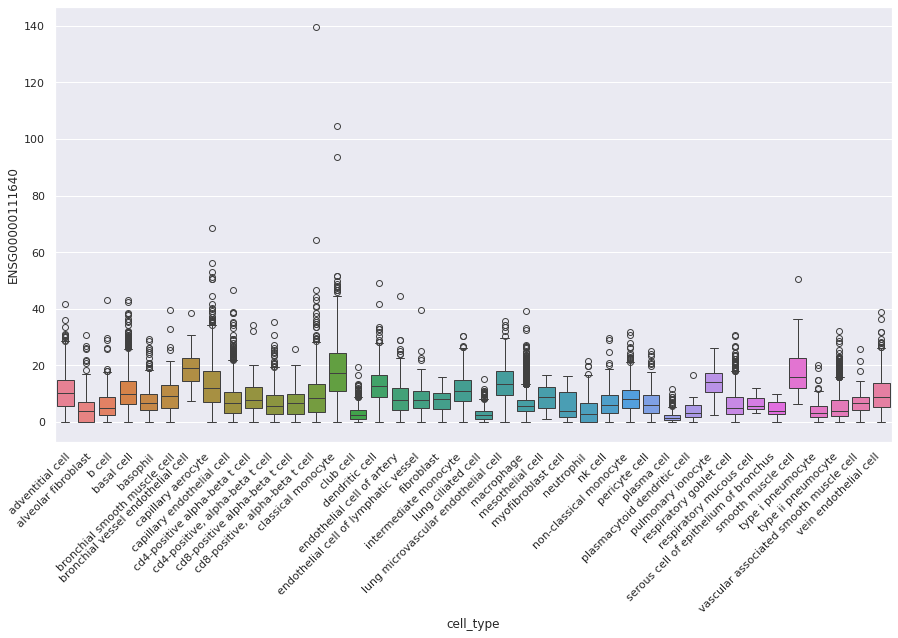

In [8]:
#boxplot of GADPH expression across all cells grouped by cell type
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = lung_counts, x = 'cell_type', y = 'ENSG00000111640', hue = 'cell_type')
sns.set(rc={'figure.figsize':(10,12)})

In [54]:
#read in median counts for all cell types
median_tabula = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')
median_lung_counts = median_tabula.loc['UBERON:0002048']

#median GADPH expression counts for each cell type
median_lung_counts['ENSG00000111640']

cell_type
adventitial cell                          10.203913
alveolar fibroblast                        3.827527
b cell                                     5.064534
basal cell                                 9.855150
basophil                                   6.664721
bronchial smooth muscle cell               9.289935
bronchial vessel endothelial cell         19.245228
capillary aerocyte                        11.906199
capillary endothelial cell                 6.626226
cd4-positive alpha-beta t cell             7.814285
cd4-positive, alpha-beta t cell            5.594961
cd8-positive alpha-beta t cell             6.582016
cd8-positive, alpha-beta t cell            8.491459
classical monocyte                        17.277014
club cell                                  2.639184
dendritic cell                            12.618114
endothelial cell of artery                 7.676679
endothelial cell of lymphatic vessel       7.701443
fibroblast                                 8.229611
in

**Histogram**

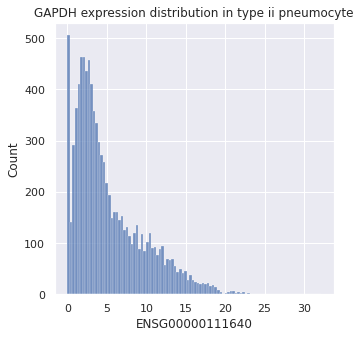

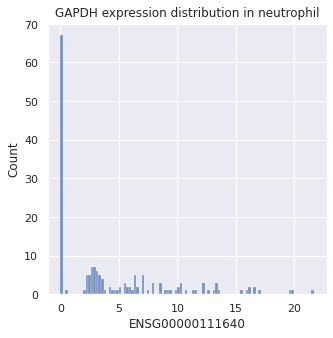

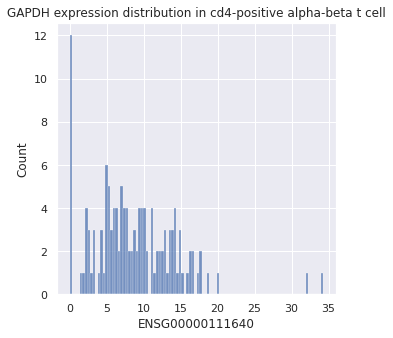

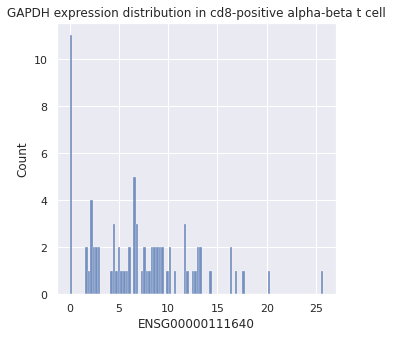

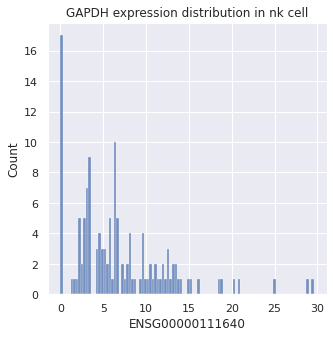

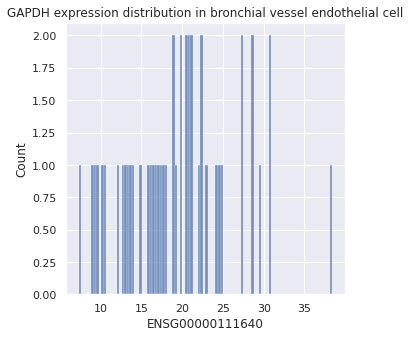

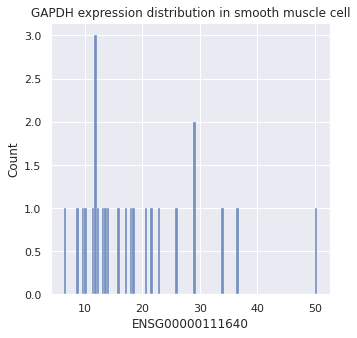

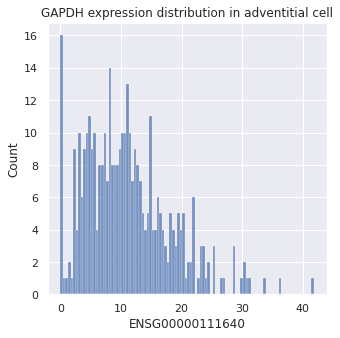

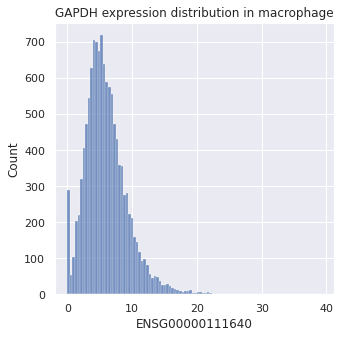

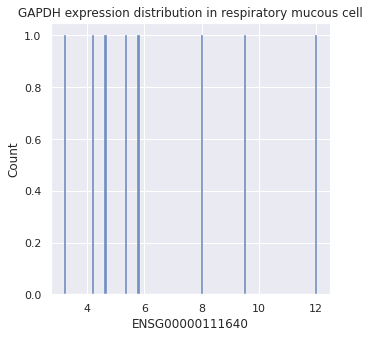

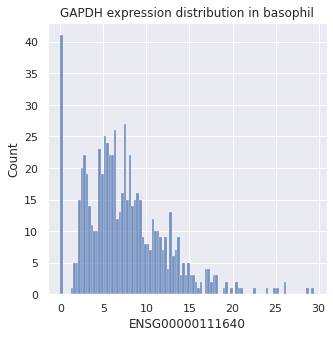

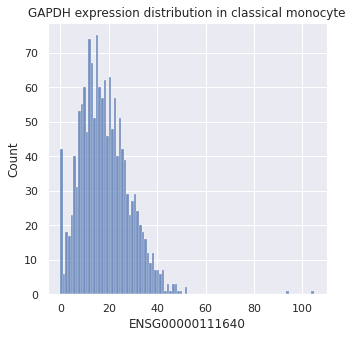

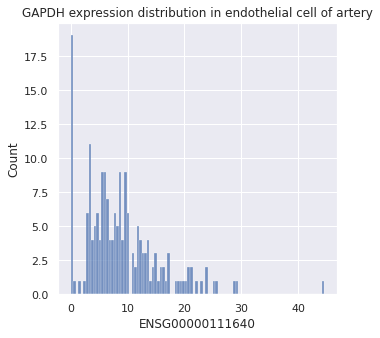

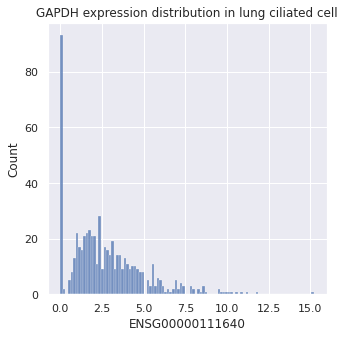

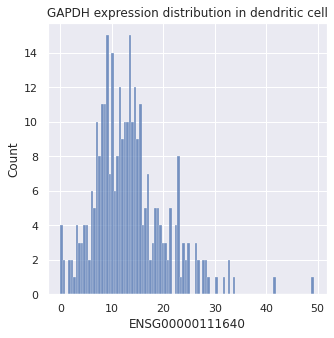

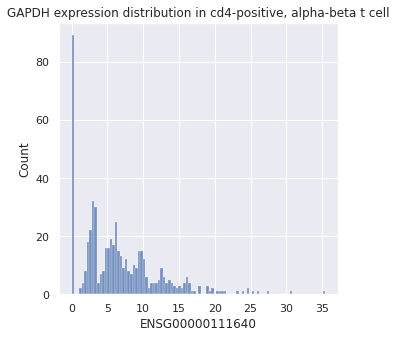

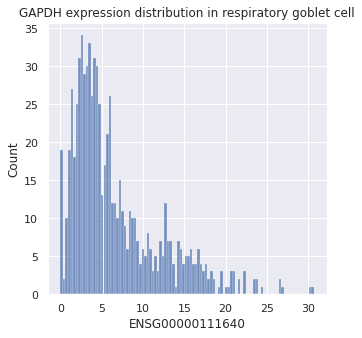

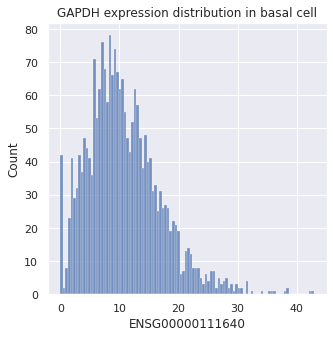

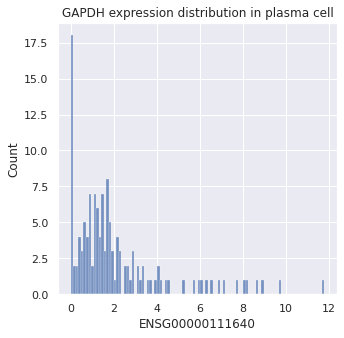

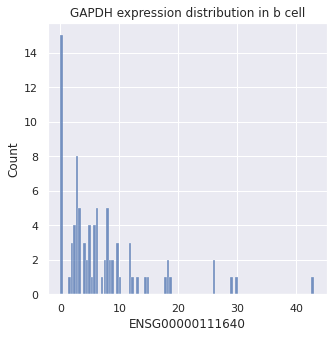

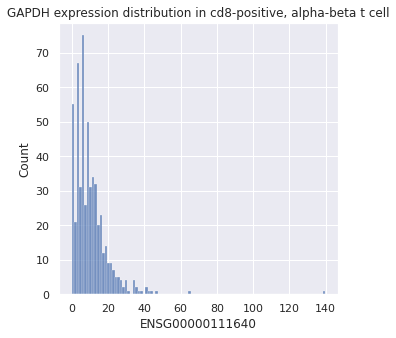

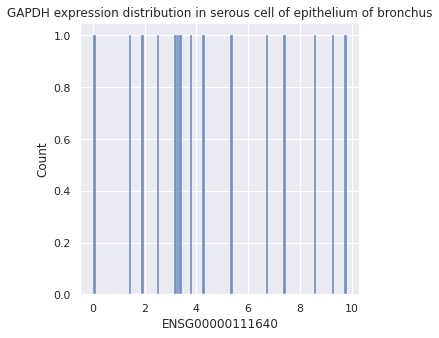

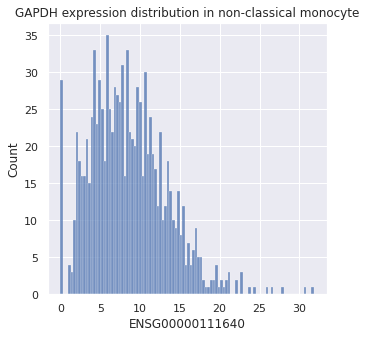

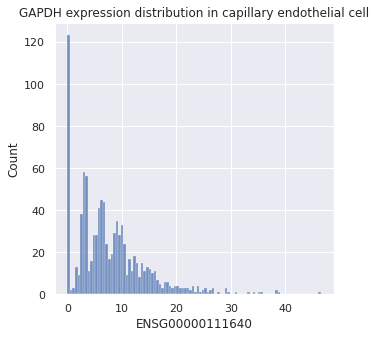

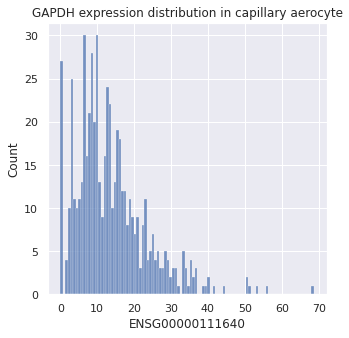

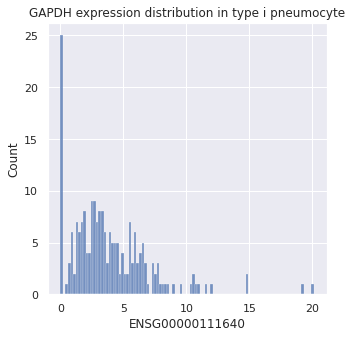

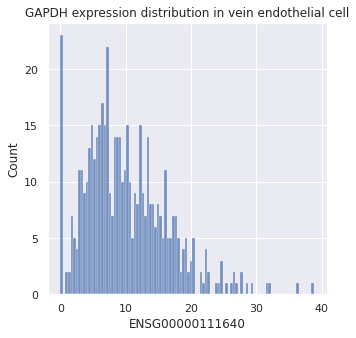

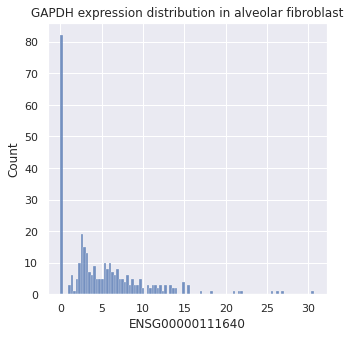

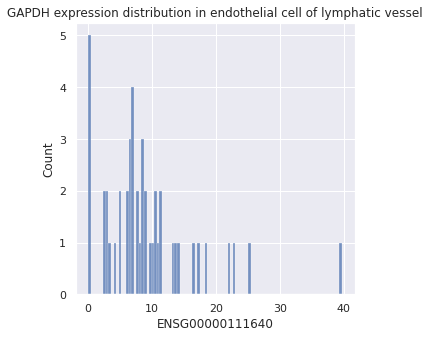

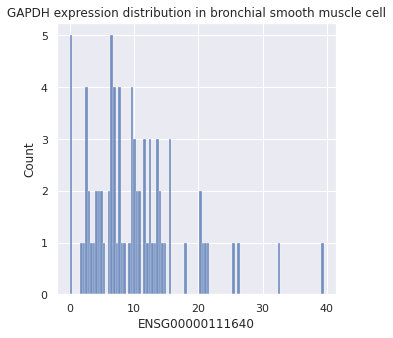

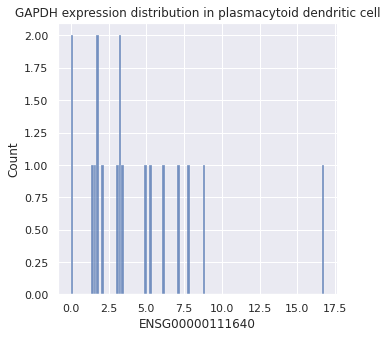

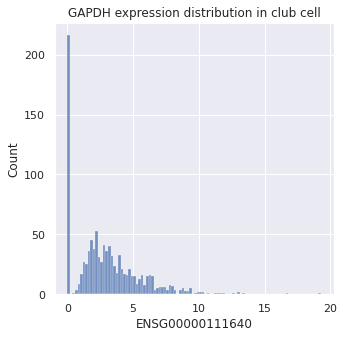

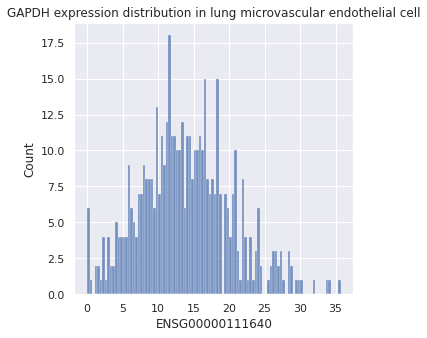

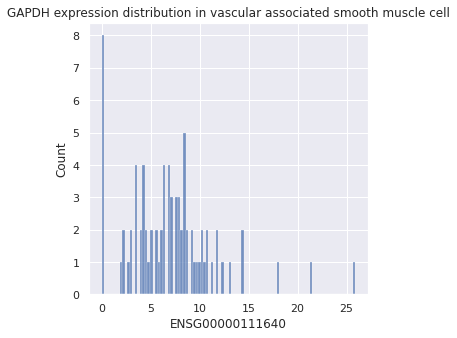

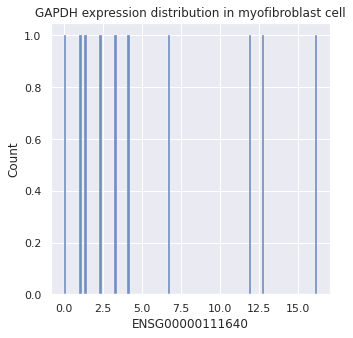

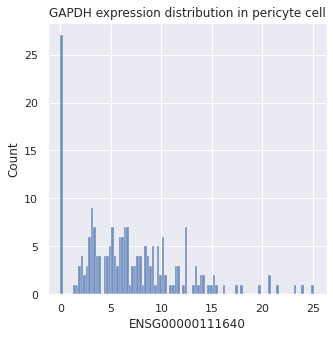

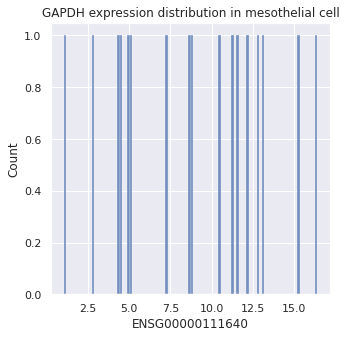

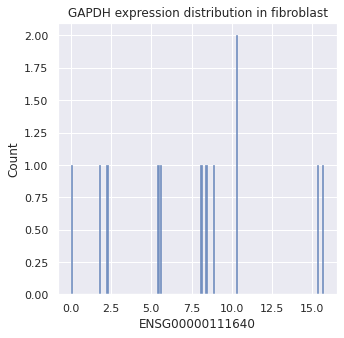

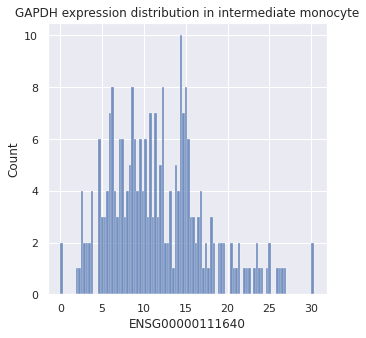

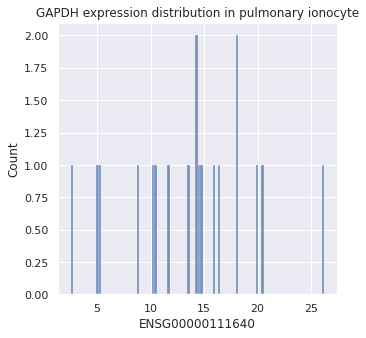

In [11]:
sns.set(rc={'figure.figsize':(5,5)})

for i in lung_counts.cell_type.unique():
    ax = sns.histplot(data = lung_counts[lung_counts.cell_type == i], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression distribution in {i}')
    plt.show()

Could a possibility be to filter out cells that have a zero expression of housekeeping genes in order to roughly get rid of cells that could have erroneous expression values. No, single-cell data is very sparse so some cells won't express housekeeping genes at any one point and since we're only sampling a couple of some rare cell types this will become apparent.

## 4.2 Whole pancreas
### 4.2.1 Read in total pancreas data

In [49]:
pancreas_counts = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

### 4.2.2 Plot GAPDH expression across all pancreas cells

**Boxplot**

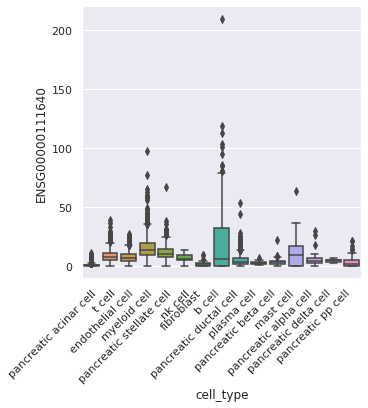

In [59]:
#boxplot of GAPDH expression across all cells grouped by cell type
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = pancreas_counts, x = 'cell_type', y = 'ENSG00000111640')
sns.set(rc={'figure.figsize':(10,8)})

In [51]:
#whole pancreas median expression counts for GAPDH across the cell types
pancreas_median_counts = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')
pancreas_median_counts['ENSG00000111640']

cell_type
b cell                       5.350012
endothelial cell             6.884168
fibroblast                   1.182767
mast cell                    9.038163
myeloid cell                13.193433
nk cell                      6.090976
pancreatic acinar cell       0.479214
pancreatic alpha cell        4.158237
pancreatic beta cell         2.842936
pancreatic delta cell        4.811918
pancreatic ductal cell       3.555940
pancreatic pp cell           1.197720
pancreatic stellate cell    10.093762
plasma cell                  1.978243
t cell                       7.375886
Name: ENSG00000111640, dtype: float64

Some cells don't express GAPDH as highly as others reflected in their median expression values and this is particularly odd when genes that are not supposed to be highly expressed in certain cells have their expression amplified and yet those cell types have a low expression of GAPDH. 

This could be the limitation of scRNA-seq since it has a high transcript dropout (only capturing 10-20% of transcripts) and sequence bias so cells that highly express other transcripts should highly express housekeeping genes but they aren't detected.

**Histogram**

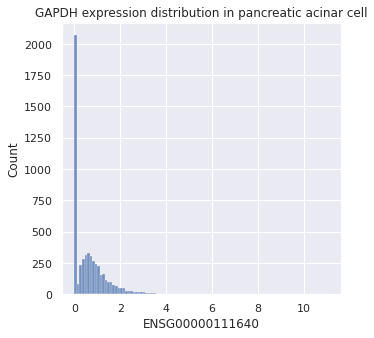

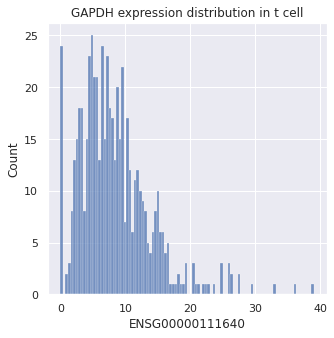

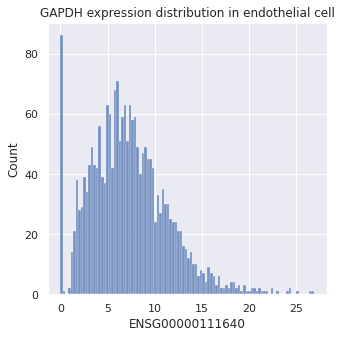

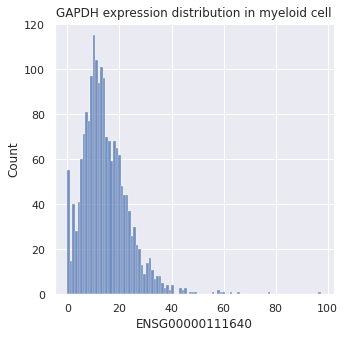

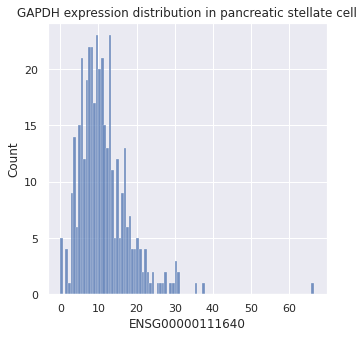

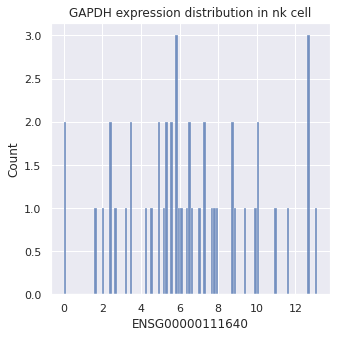

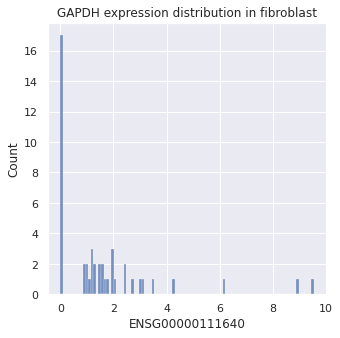

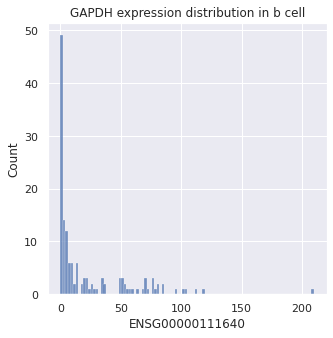

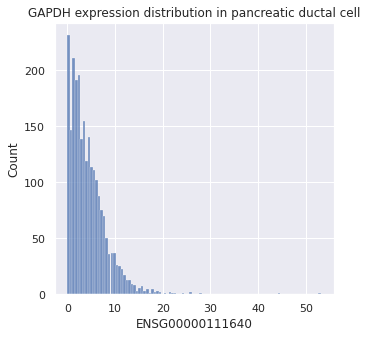

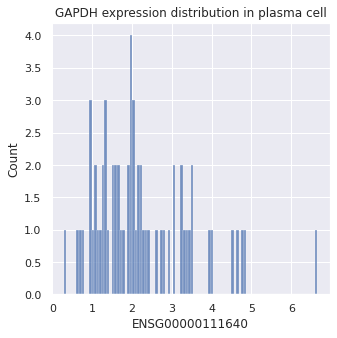

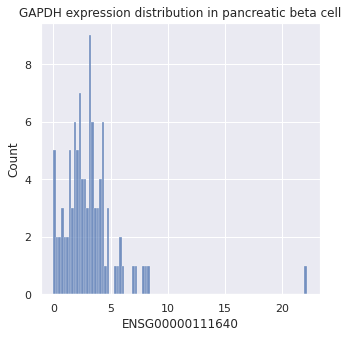

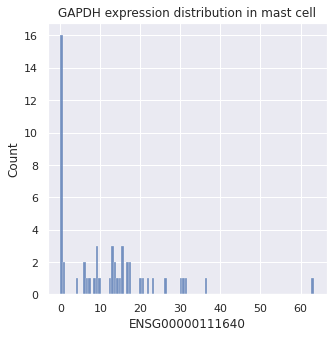

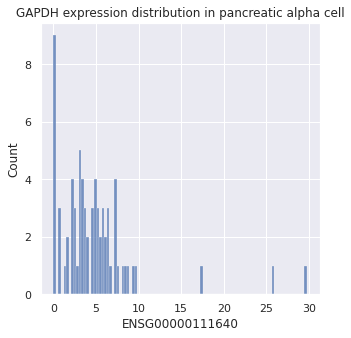

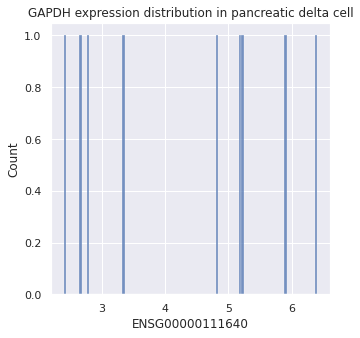

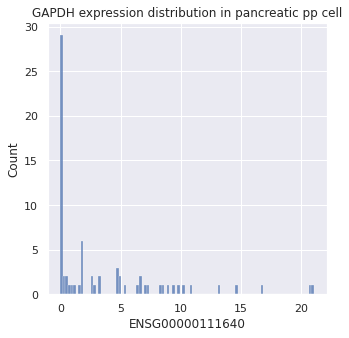

In [60]:
sns.set(rc={'figure.figsize':(5,5)})

#plot GAPDH expression histogram across each cell type
for i in pancreas_counts.cell_type.unique():
    ax = sns.histplot(data = pancreas_counts[pancreas_counts.cell_type == i], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression distribution in {i}')
    plt.show()

# 5. GAPDH expression in macrophages across different tissues

In [17]:
#create expression df for macrophages across different tissues
macrophage = all_cells_adata[all_cells_adata.obs.cell_ontology_class == 'macrophage']
macrophage_counts = processing(macrophage)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


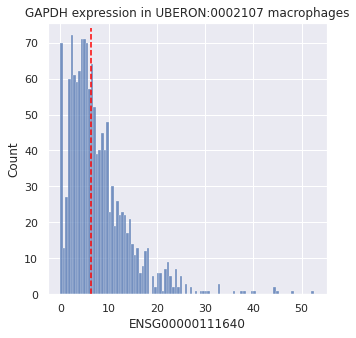

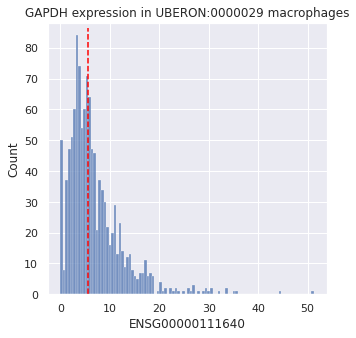

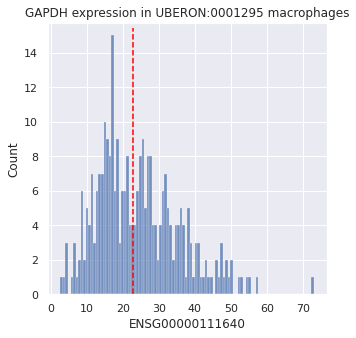

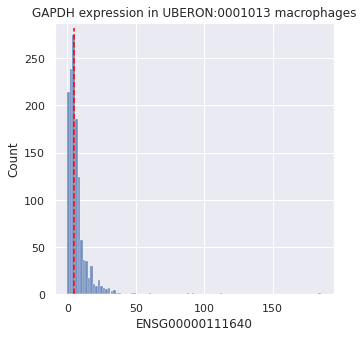

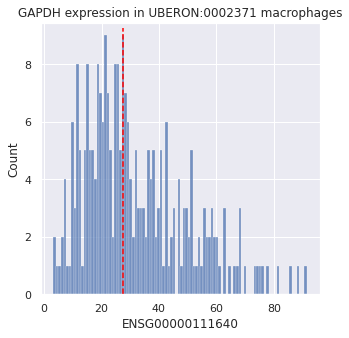

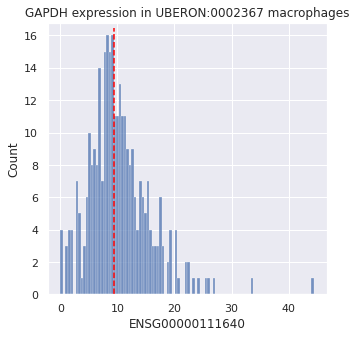

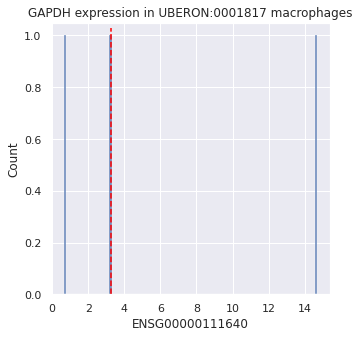

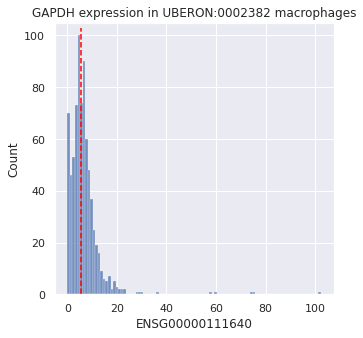

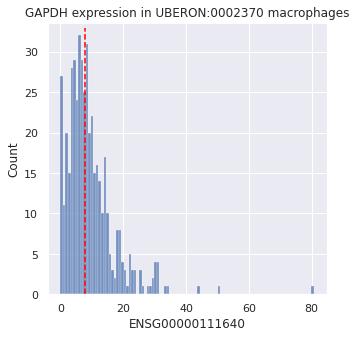

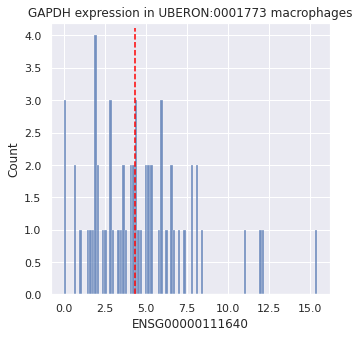

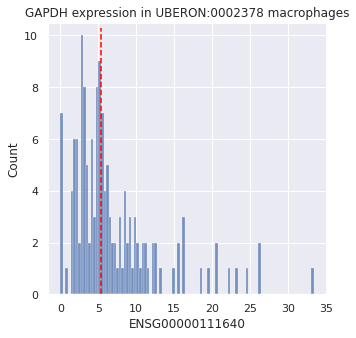

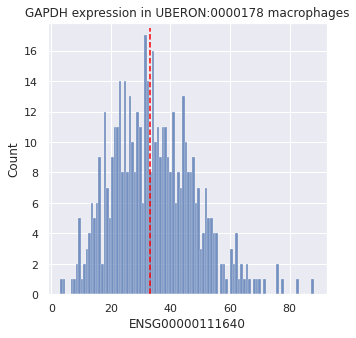

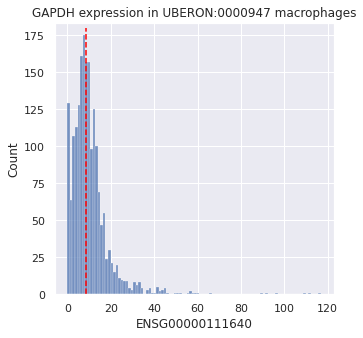

In [18]:
#plot GAPDH expression histogram for each set of tissue macrophages
for i in range(0, macrophage_counts.tissue.nunique(), 3):
    
    #tissue
    tissue = macrophage_counts.tissue.unique()[i]
    
    #plot histogram
    ax = sns.histplot(data = macrophage_counts[macrophage_counts.tissue == tissue], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression in {tissue} macrophages')
    
    #draw median dashed line
    ax.axvline(x = macrophage_counts[macrophage_counts.tissue == tissue]['ENSG00000111640'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')
    
    plt.show()

All the tissues appear to have a normal distribution for this cell type with the GAPDH expression so it might be worth using the median without the zero counts. However, this is probably not suitable as we do want to show a zero expression for cells which have a majority zero expression; it might be best to consider an approach with an expression threshold and a threshold for the minimum number of observations required to make an accurate estimation of the median expression count for the cell type in a given tissue.

This shows the median expression of GAPDH for macrophages across the different tissues is a pretty good metric for most tissues and this is especially true when the number of cells is greater in these tissues as expected and it performs more poorly when the cell count is much lower. It also shows that the same cell type in different tissues can have different expression values and expression distributions for housekeeping genes.

# 6. Is there any exact duplication of cells? (following from 2.3.1)
## 6.1 Load total pancreas cells

In [2]:
total_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

## 6.2 Count total number of each pancreatic cell type

In [6]:
total_pancreas.groupby('cell_type').cell_type.count()

cell_type
b cell                       144
endothelial cell            2100
fibroblast                    47
mast cell                     53
myeloid cell                1862
nk cell                       47
pancreatic acinar cell      5534
pancreatic alpha cell         71
pancreatic beta cell          99
pancreatic delta cell          9
pancreatic ductal cell      2431
pancreatic pp cell            71
pancreatic stellate cell     393
plasma cell                   63
t cell                       573
Name: cell_type, dtype: int64

## 6.3 Count number of each cell type across endocrine and exocrine pancreas

In [9]:
#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

#processing exocrine and endocrine pancreas count data
exo_pancreas = processing(exo_pancreas_adata)
endo_pancreas = processing(endo_pancreas_adata)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)

cell_type_counts = pd.DataFrame(exo_pancreas.groupby('cell_type').cell_type.count())
cell_type_counts = cell_type_counts.rename(columns = {'cell_type': 'exo_count'})
cell_type_counts['endo_count'] = endo_pancreas.groupby('cell_type').cell_type.count()

cell_type_counts

exo_count  endo_count
cell_type                                      
b cell                           27       117.0
endothelial cell               1927       173.0
fibroblast                       47         NaN
mast cell                         2        51.0
myeloid cell                   1805        57.0
nk cell                          47         NaN
pancreatic acinar cell         5092       442.0
pancreatic alpha cell            46        25.0
pancreatic beta cell             88        11.0
pancreatic delta cell             9         NaN
pancreatic ductal cell         1892       539.0
pancreatic pp cell                1        70.0
pancreatic stellate cell        386         7.0
plasma cell                      63         NaN
t cell                          545        28.0

It doesn't appear from first glance that any of the cells within the cell types have been exactly duplicated across the endocrine and exocrine pancreas since none have the exact same number of each cell type.

## 6.4 Look into whether any two cells have exactly the same expression vector across all genes

In [48]:
gene_columns = total_pancreas.drop(columns = 'cell_type').columns.to_list()
duplicate_rows = total_pancreas.drop(columns = 'cell_type').duplicated(subset = gene_columns, keep = False)
duplicate_rows.unique()

array([False])

From this code, there appears to be NO duplicated cells in this data meaning that the duplicated expression values are due to an upper limit in the expression.

# 7. Plot 100 histograms of expression across different tissues, cell-types and genes

The KDE is a good way of looking at the most accurate average expression however it would be extremely slow when scaled up to the entire dataset and thus a better approach is required. I also saw that the median is a good metric in most cases when the number of cells in a cell type was large enough therefore I need to look at more distributions of genes across cell types to determine a good expression/observation threshold.

## 7.1 Generate random tissues, cell-types and genes

In [3]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [5]:
import random

random_tissues = random.sample(tabula.tissue.unique().tolist(), k = 2)
tissue1 = tabula[tabula['tissue'] == random_tissues[0]]
tissue2 = tabula[tabula['tissue'] == random_tissues[1]]

random_cell_type1 = random.sample(tissue1.cell_type.unique().tolist(), k = 5)
random_cell_type2 = random.sample(tissue2.cell_type.unique().tolist(), k = 5)
random_genes = random.sample(tabula.columns[1:].tolist(), k = 10)
random_genes.insert(0, 'cell_type')

## 7.2 Tissue 1

In [6]:
tissue1_df = tabula[(tabula['tissue'] == random_tissues[0]) & (tabula['cell_type'].isin(
    random_cell_type1))].loc[:, random_genes].reset_index(drop = True)

In [7]:
#aggregate expression values from each cell into cell type
agg_tissue1_df = tissue1_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue1_df = agg_tissue1_df.loc[random_cell_type1]

/tmp/ipykernel_16251/2614683954.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue1_df = tissue1_df.groupby('cell_type').agg(lambda x: list(x))


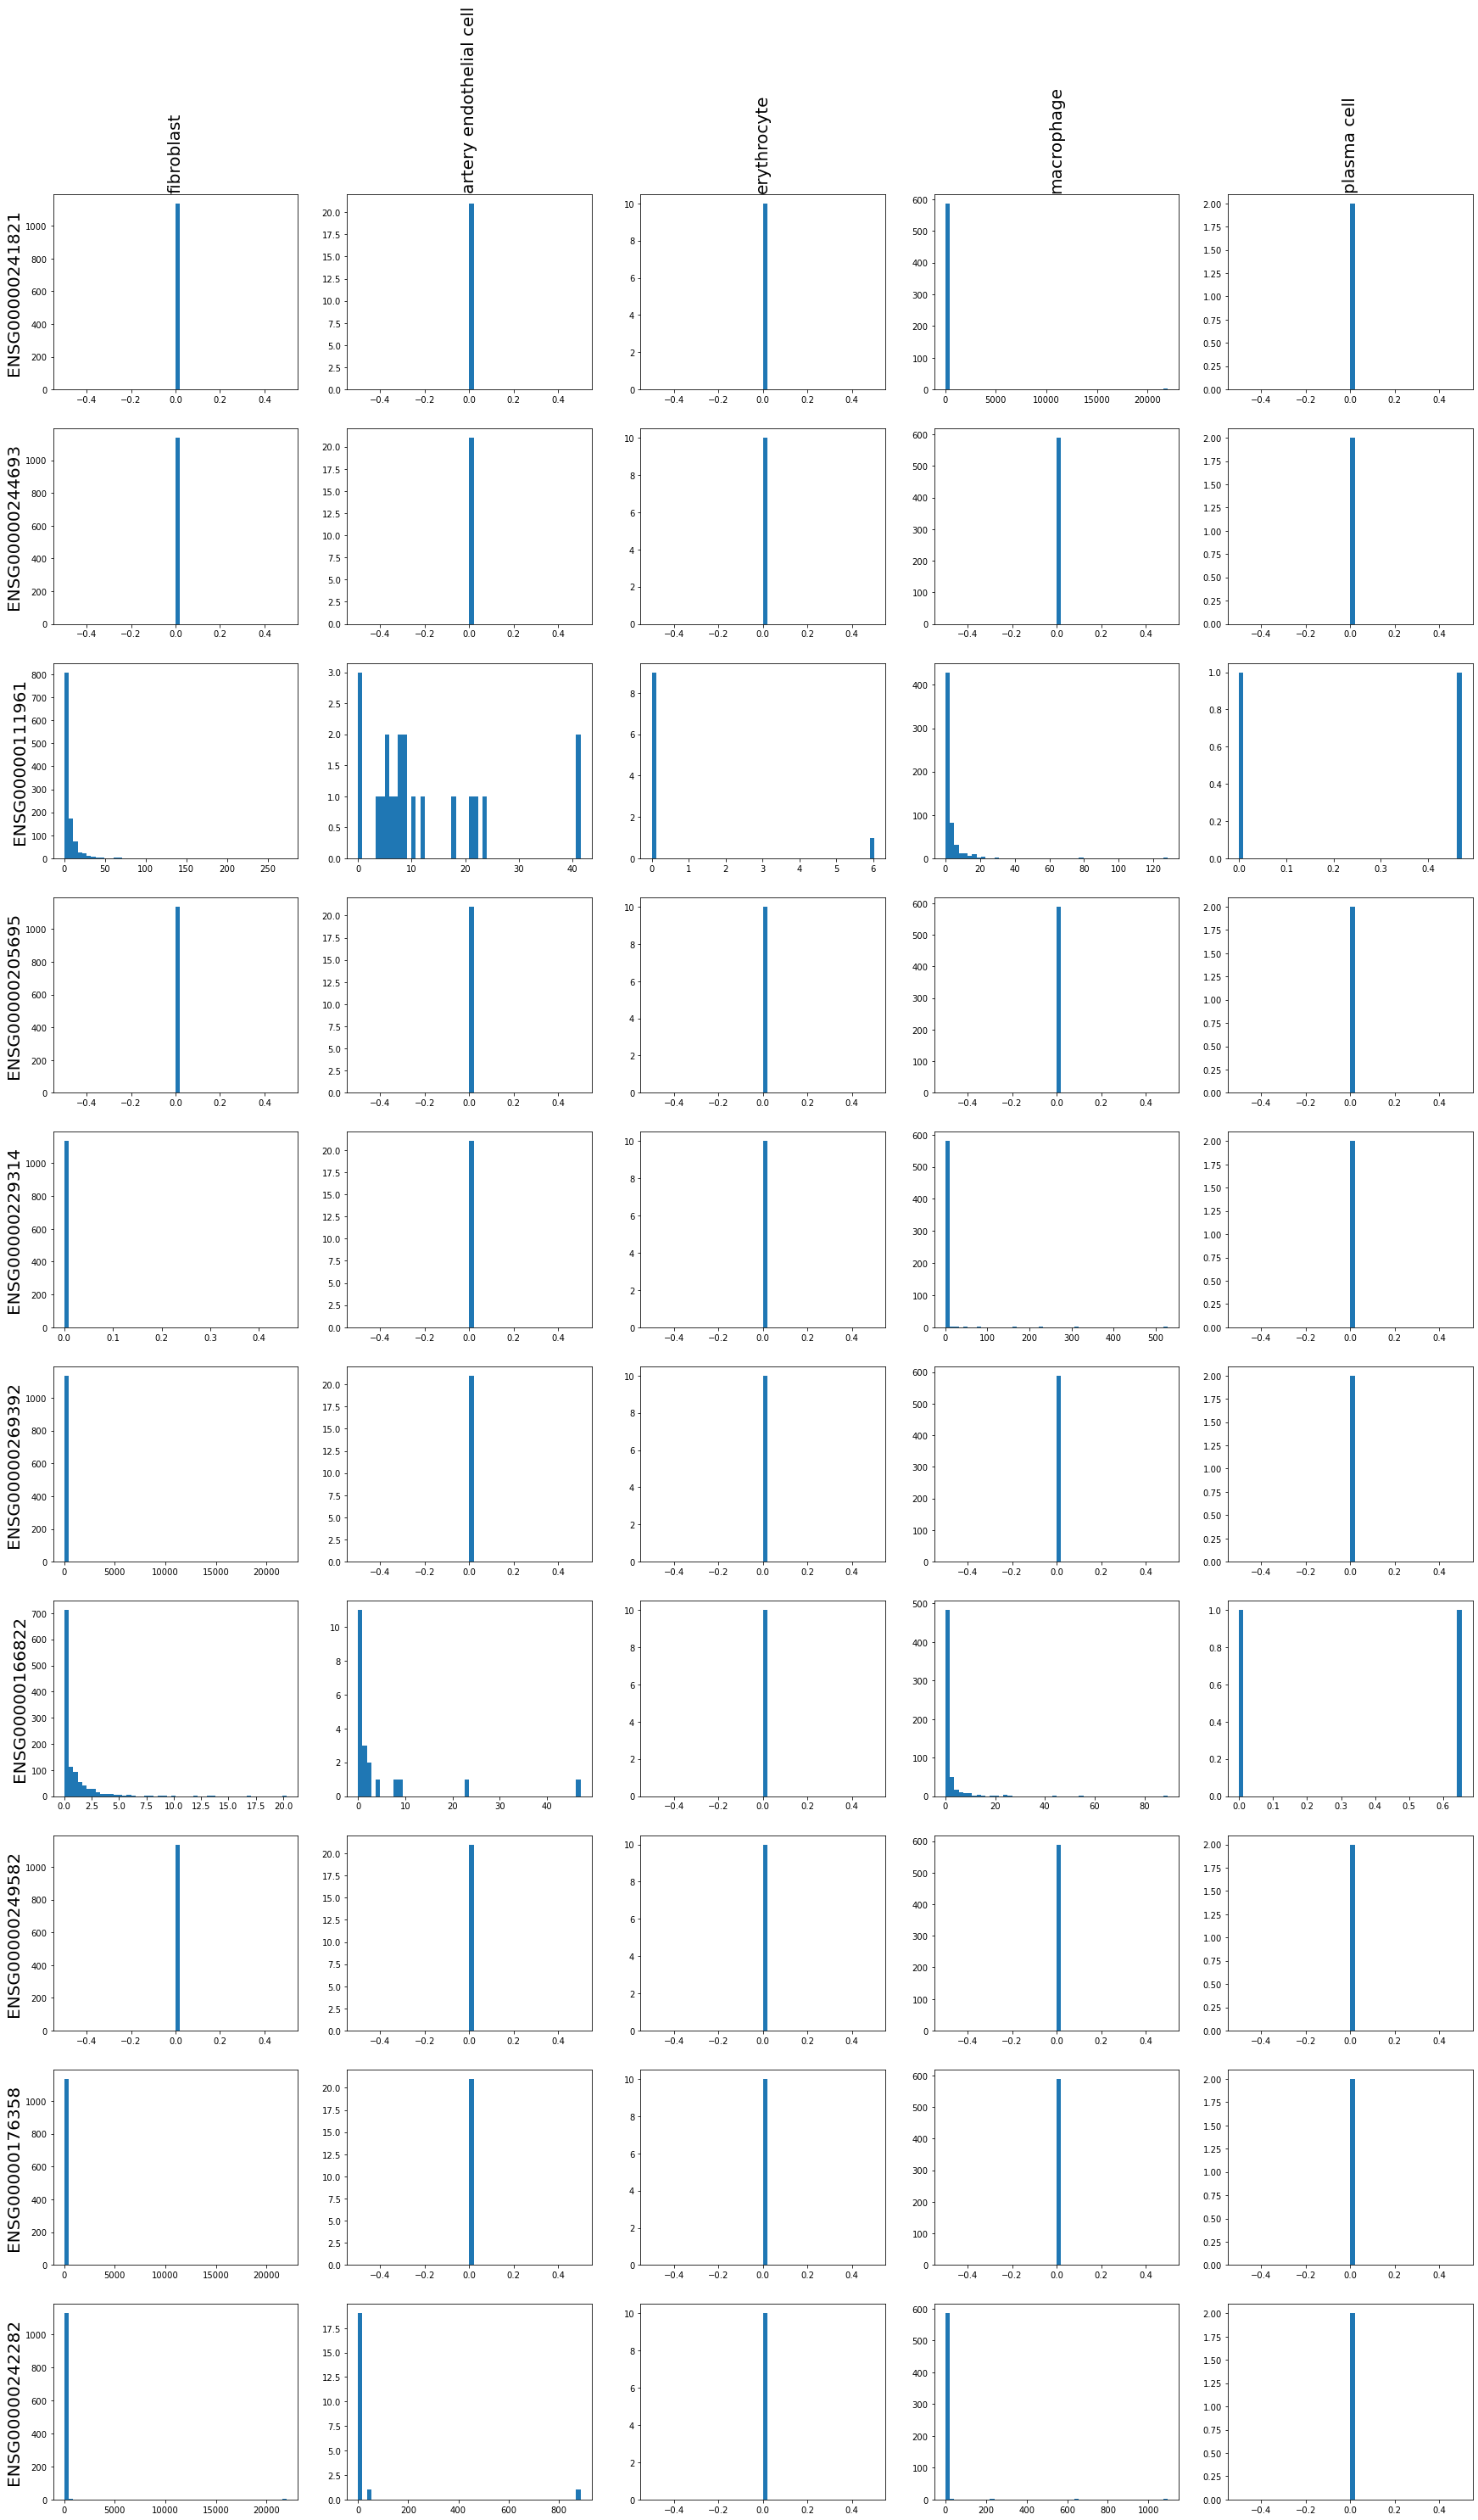

In [11]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue1_df.index.to_list()
genes = agg_tissue1_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue1_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20, rotation = 'vertical')
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually from separate tab

## 10.3 Tissue 2

In [8]:
tissue2_df = tabula[(tabula['tissue'] == random_tissues[1]) & (tabula['cell_type'].isin(
    random_cell_type2))].loc[:, random_genes].reset_index(drop = True)

agg_tissue2_df = tissue2_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue2_df = agg_tissue2_df.loc[random_cell_type2]

/tmp/ipykernel_16251/3325214390.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue2_df = tissue2_df.groupby('cell_type').agg(lambda x: list(x))


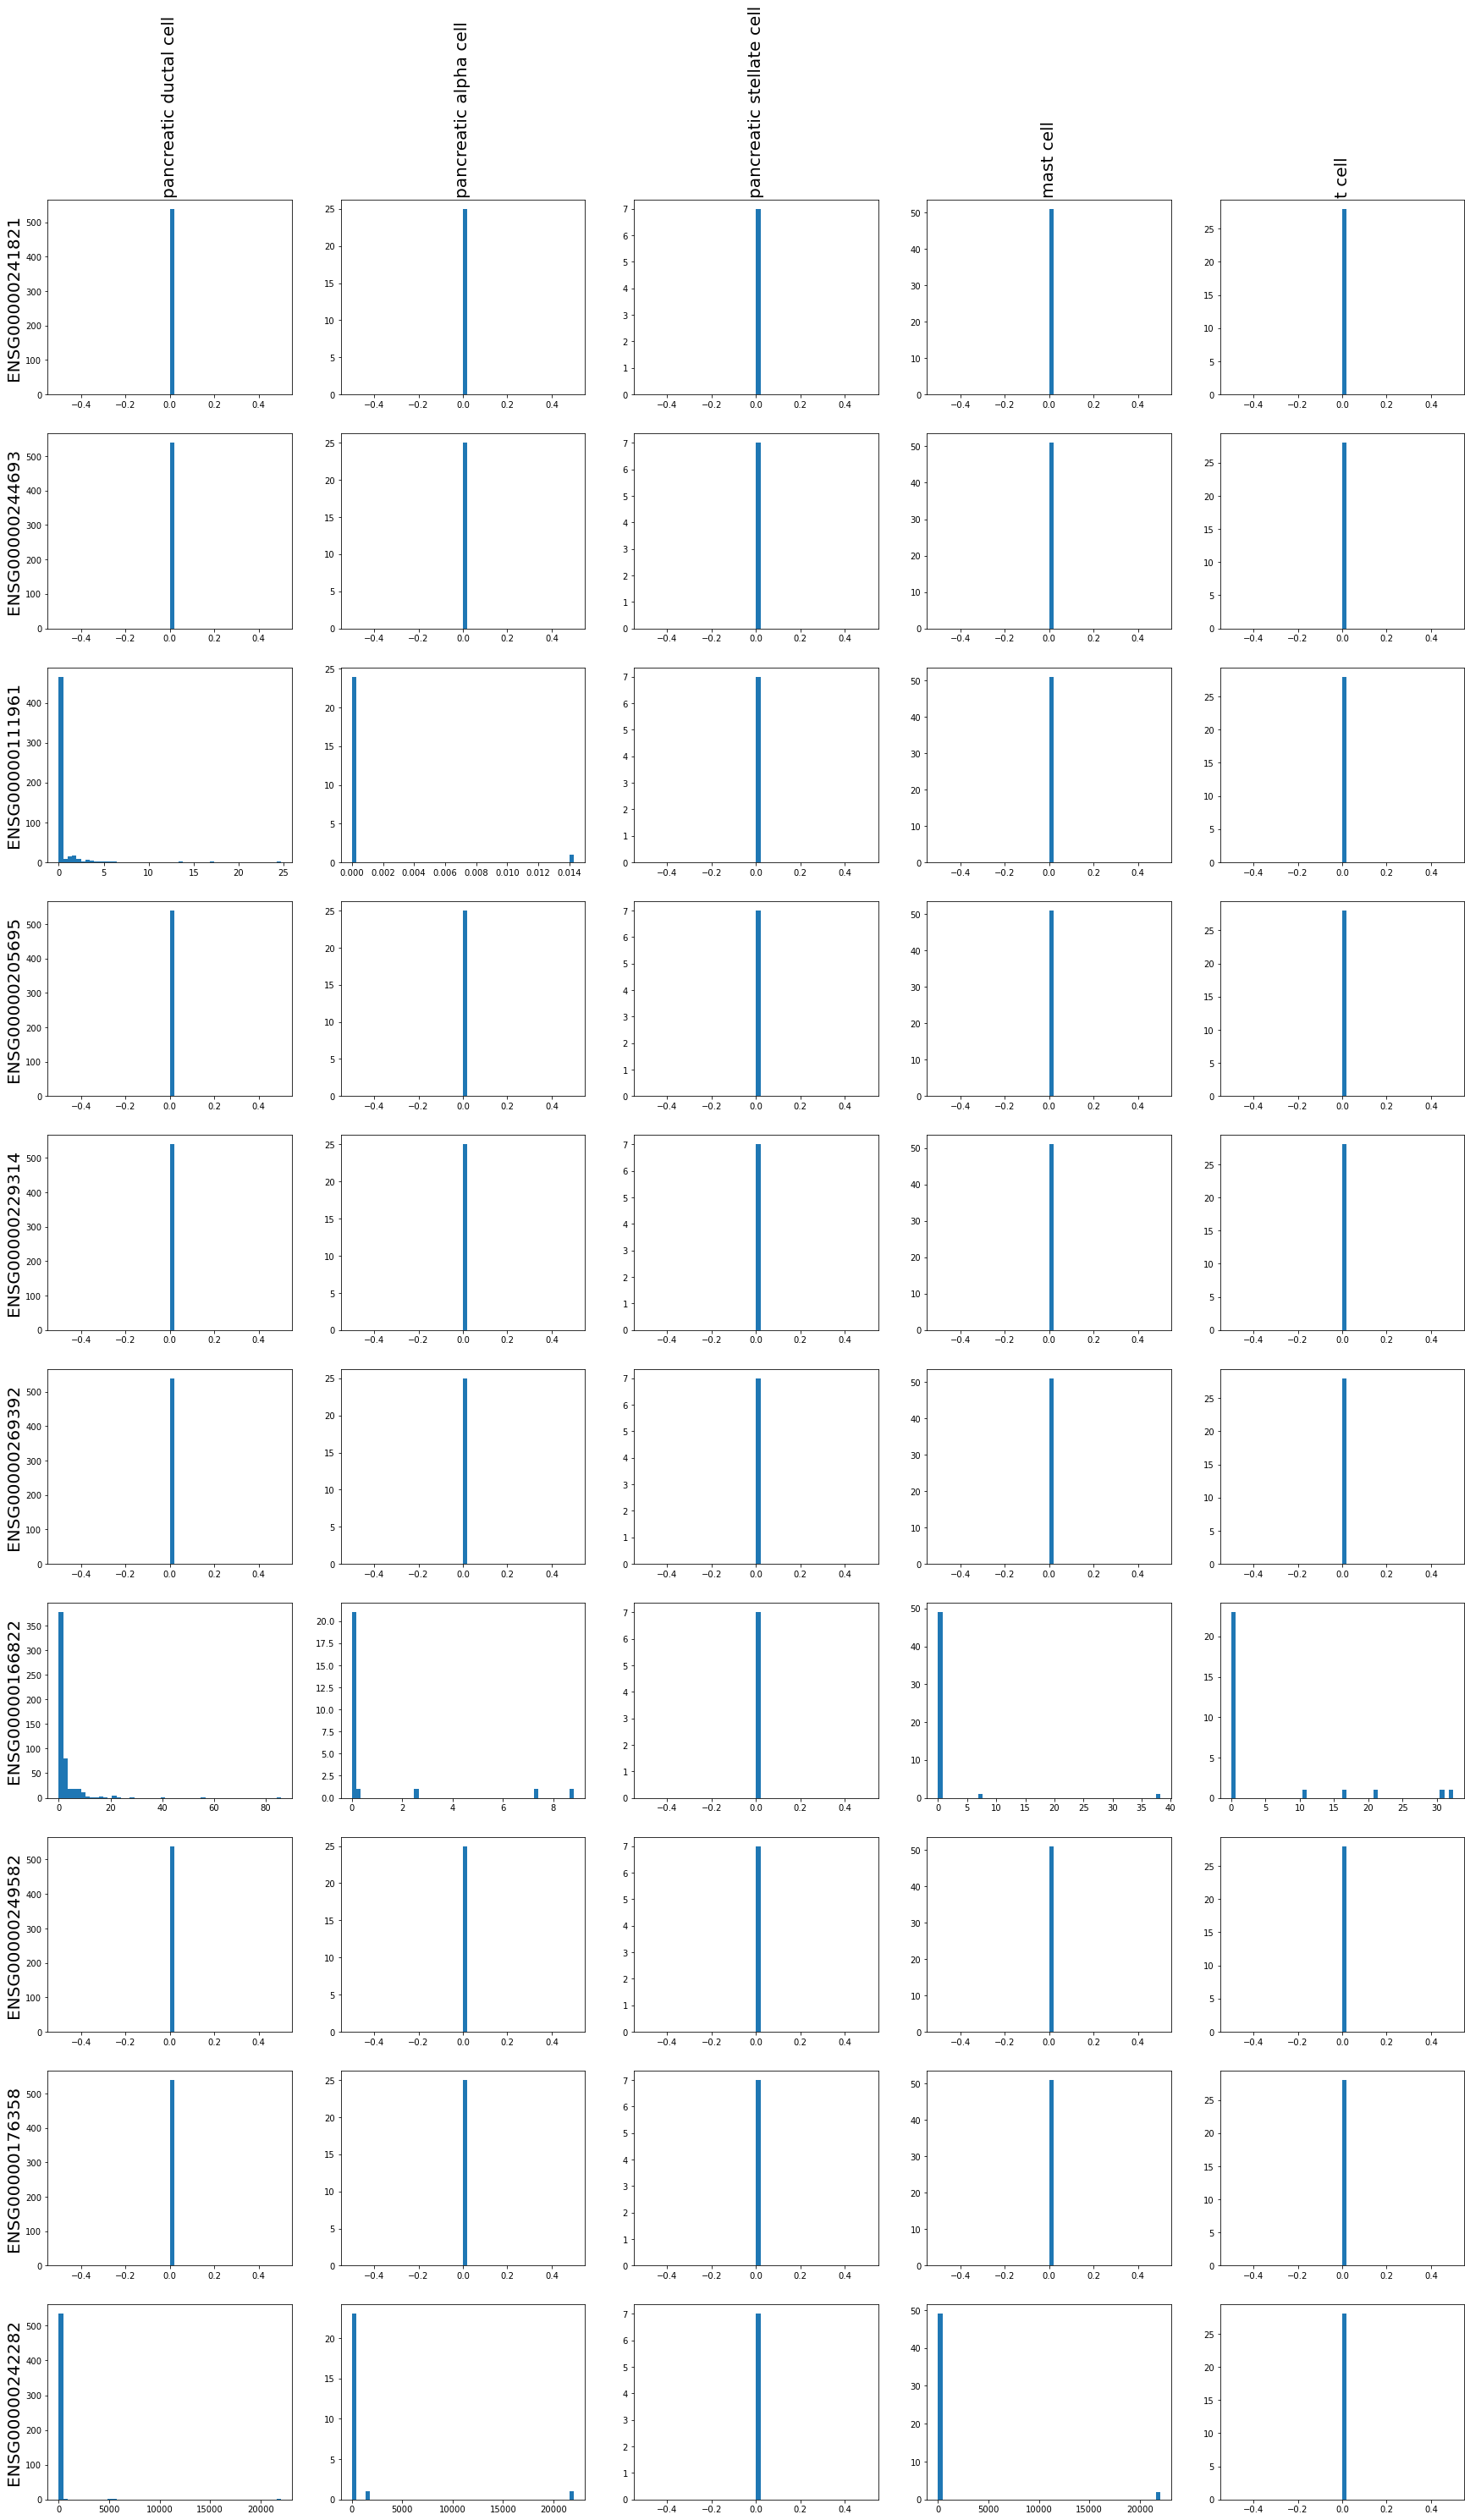

In [10]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue2_df.index.to_list()
genes = agg_tissue2_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue2_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20, rotation = 'vertical')
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually by opening in new tab and saving

The problem here is that the randomly chosen genes all have expressions which are centred on zero therefore I need to chose random data from cell types which have non-zero expressions of genes.

## 7.4 Chose random tissues that have a bigger spread of data

In [9]:
import random

tissue = tabula[tabula['tissue'] == 'UBERON:0002107']
random_cell_type = random.sample(tissue.cell_type.unique().tolist(), k = 5)

random_genes = tissue.columns[-10:].tolist()
random_genes.insert(0, 'cell_type')

In [10]:
tissue_df = tabula[(tabula['tissue'] == 'UBERON:0002107') & (tabula['cell_type'].isin(
    random_cell_type))].loc[:, random_genes].reset_index(drop = True)

agg_tissue_df = tissue_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue_df = agg_tissue_df.loc[random_cell_type]

/tmp/ipykernel_16251/3627287297.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue_df = tissue_df.groupby('cell_type').agg(lambda x: list(x))


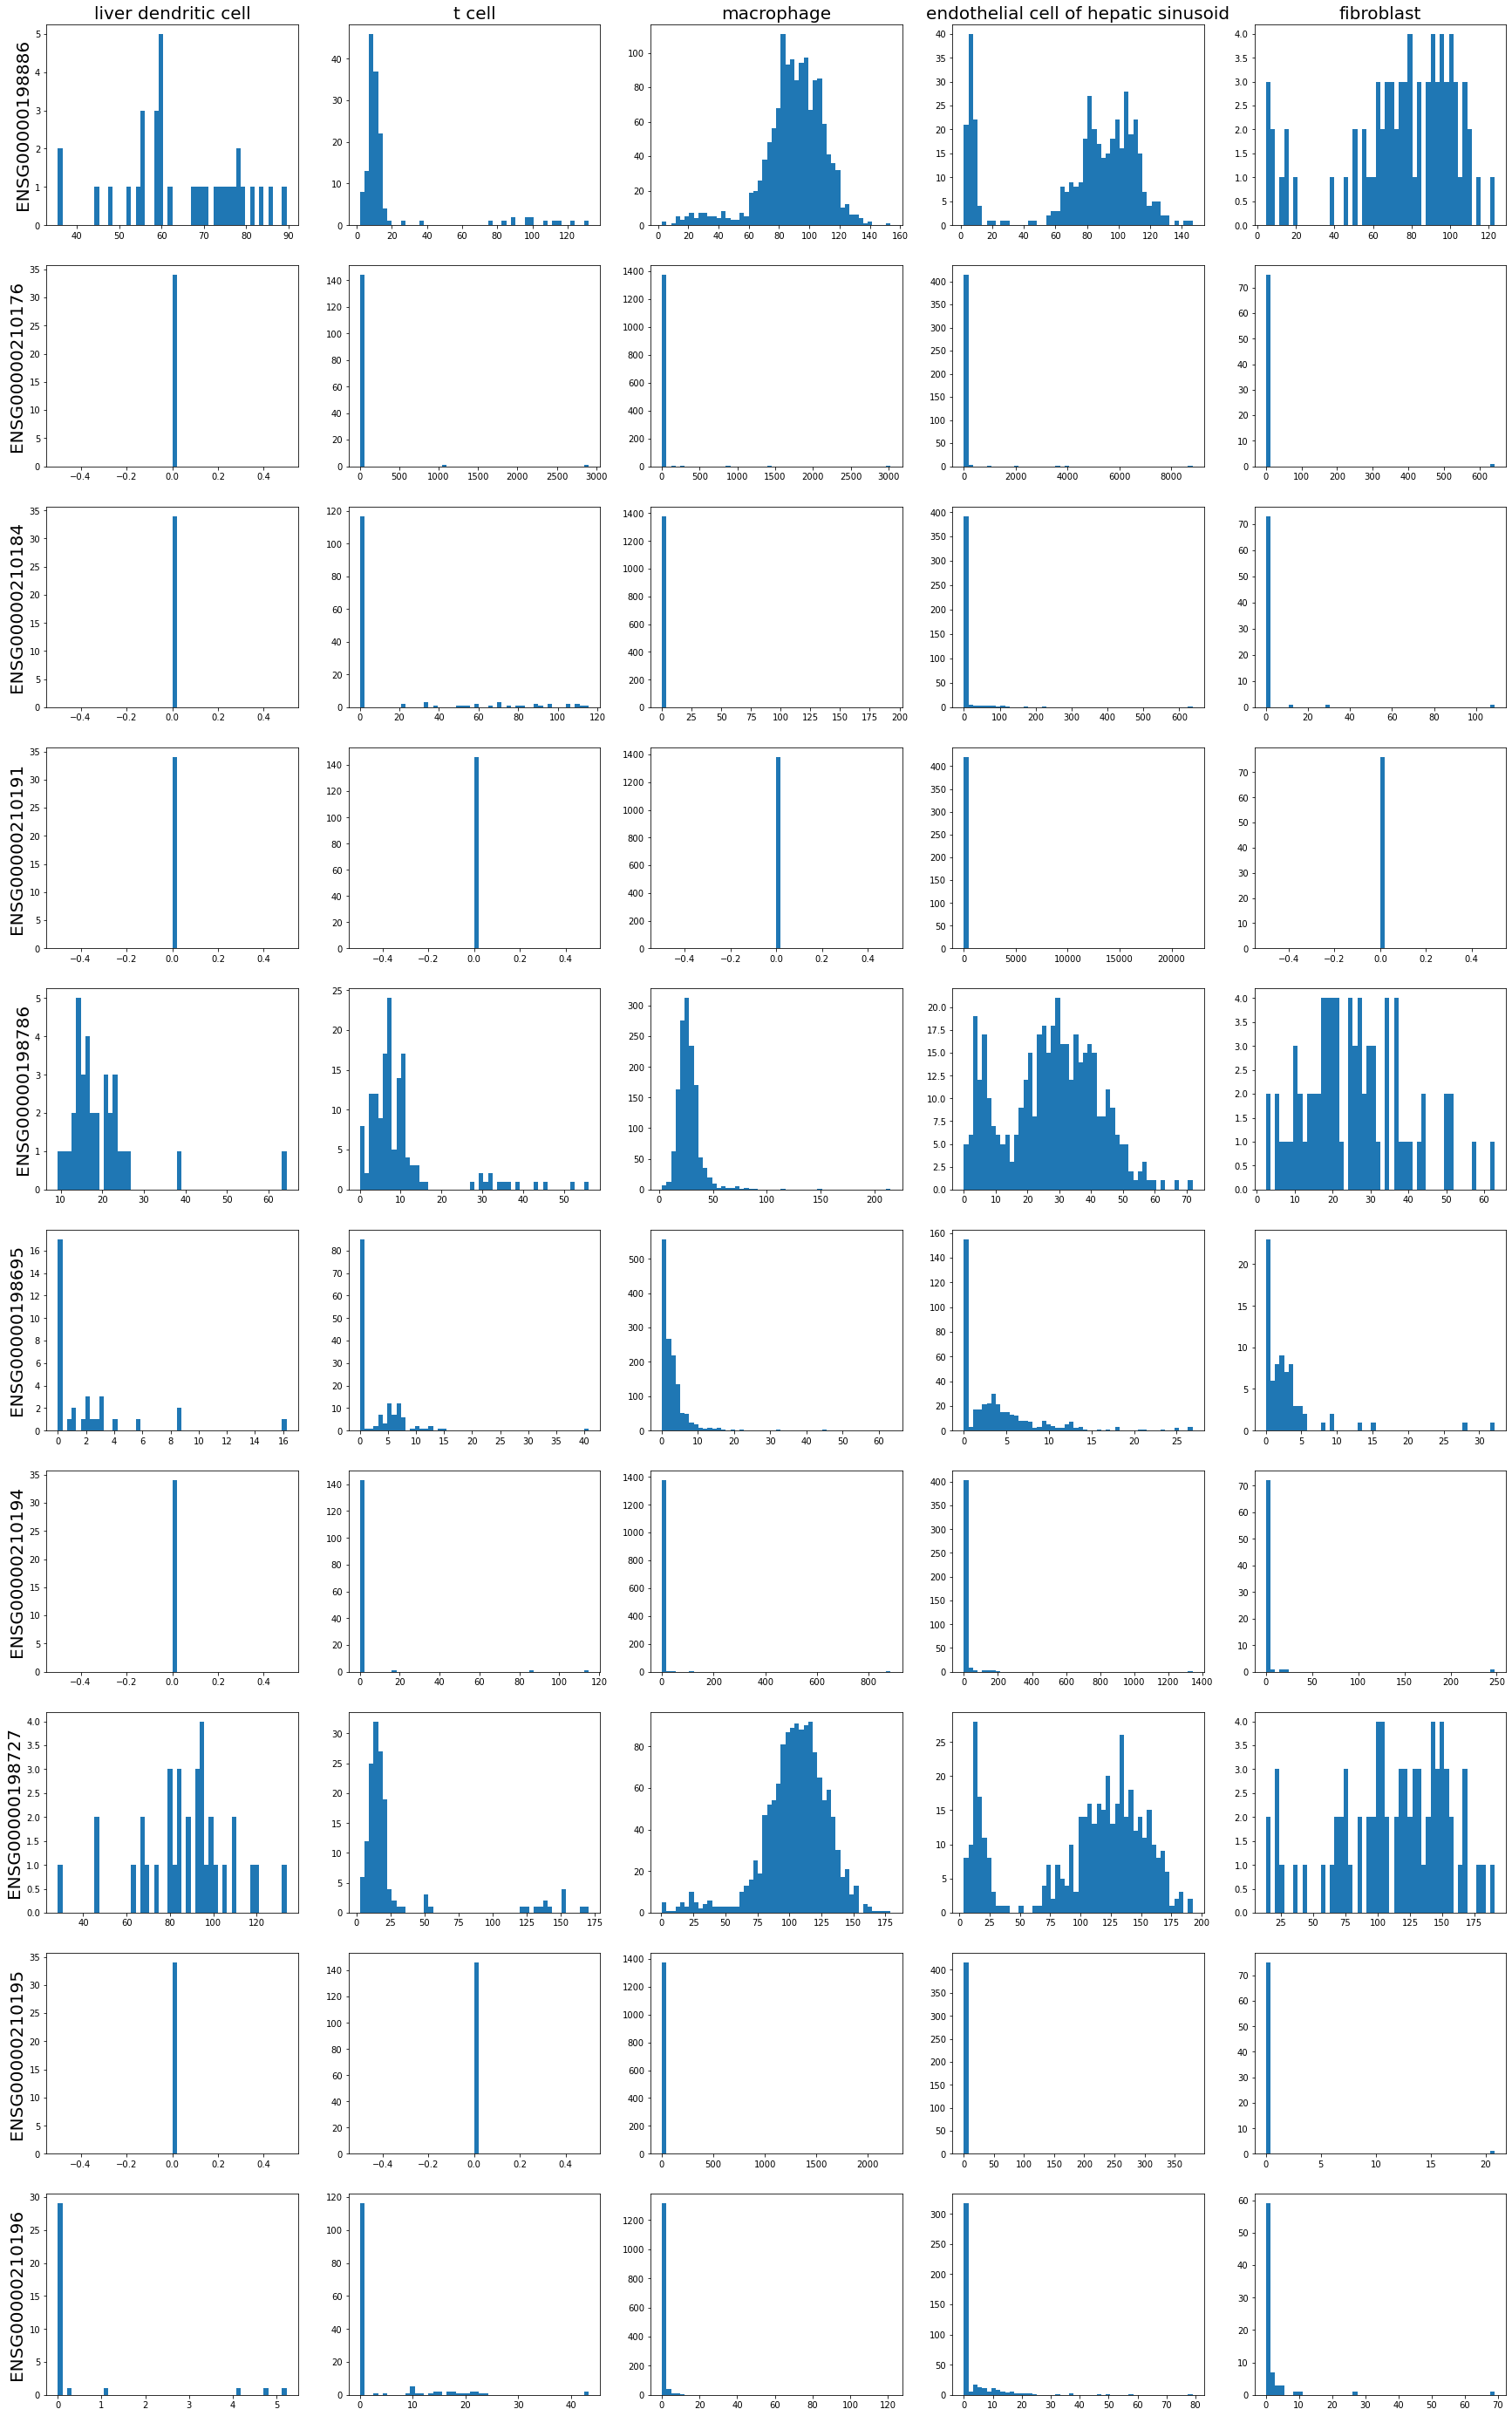

In [25]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue_df.index.to_list()
genes = agg_tissue_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20)
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually from separate tab

# 8. Developing new average metric for counts

The KDE plots are useful for identifying the best median/mode value of expression accounting for the zero expression seen in many cells however it is computationally complex and would not bode well over millions of values therefore a more simple metric is required.

Most distributions are unimodal and don't appear to blend with the zero count expressions meaning there is a visible gap between the zero count expression and the rest of the distribution.

## 8.1 Read in tabula data and convert to dense

In [2]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [28]:
#set multi-index
tabula.set_index(['tissue', 'cell_type'], inplace = True)

**Machine larger than n2-highmem-8 required to run the next step**

In [ ]:
tabula_dense = tabula.sparse.to_dense()

## 8.2 Define average_metric function

In [6]:
#define minimum expression threshold for counts
MIN_EXPRESSION_THRESHOLD = 1
    
#define minimum number of observations to calculate median metric
MIN_OBSERVED_THRESHOLD = 10

def average_metric(df):
    
    # Set all values < expression threshold, including zeroes, to nan.
    df[df < MIN_EXPRESSION_THRESHOLD] = np.nan
    
    # Compute median expression values for all genes.
    median = df.median()
    
    # Filter out genes where we have too few observations.
    observation_mask = (~ df.isna()).sum() < MIN_OBSERVED_THRESHOLD
    median[observation_mask] = np.nan
    
    return median

## 8.3 Run process through pandarallel

Running the function by grouping by tissue and cell type and aggregating by the function is a very slow process and thus for computational efficiency I can run the aggregation through pandarallel that parallelises the apply function. However, in order to do this need to use multi-indexing which is why I set the index in the previous part.

In [7]:
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
%%time

#create adjusted median counts dataframe for all cells in tabula sapiens
median_tabula_counts = tabula_dense.groupby(['tissue', 'cell_type'], observed=True).parallel_apply(average_metric)
median_tabula_counts

CPU times: user 2min 5s, sys: 3min 3s, total: 5min 8s
Wall time: 7min 17s


ENSG00000223972  ENSG00000227232  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000278267  ENSG00000243485  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000237613  ENSG00000268020  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000240361  ENSG00000186092  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

In [9]:
median_tabula_counts.to_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

## 8.4 How many genes have NaN expression across all cell types?

In [12]:
tabula_median = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

In [14]:
#remove columns where all the values are NaN
tabula_median.dropna(axis = 1, how = 'all')

ENSG00000227232  ENSG00000238009  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000233750  ENSG00000268903  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000269981  ENSG00000241860  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000241599  ENSG00000279457  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

Since 39,431 genes remain this means that from our metric 17,611 genes were dropped. This is compared to 24,166 genes retained when we dropped the zero median expression counts showing that our metric is less affected by the zero counts.

# 9. Mitochondrial-encoded genes
## 9.1 Access list of mitochonrial-encoded genes from ENSEMBL

In [11]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name', 'chromosome_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [12]:
#subset out genes that are present on MT chromosome
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Chromosome/scaffold name'] == 'MT']

#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

## 9.2 Search Tabula Sapiens for mitochondrial-encoded genes

In [5]:
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')
tabula.var.filter(items = mt_encoded_genes, axis = 0)

feature_type  highly_variable     means  dispersions  \
ensemblid                                                                  
ENSG00000210049  Gene Expression            False  0.007144     1.878539   
ENSG00000211459  Gene Expression            False  4.580986     5.332270   
ENSG00000210077  Gene Expression            False  0.212312     1.397942   
ENSG00000210082  Gene Expression            False  5.600650     6.355399   
ENSG00000209082  Gene Expression            False  0.059871     2.182837   
ENSG00000198888  Gene Expression            False  3.540140     4.105647   
ENSG00000210100  Gene Expression            False  0.016011     0.404683   
ENSG00000210107  Gene Expression            False  0.020427     0.575981   
ENSG00000210112  Gene Expression            False  0.160283     0.935489   
ENSG00000198763  Gene Expression            False  3.482217     4.073226   
ENSG00000210117  Gene Expression            False  0.004593     0.443947   
ENSG00000210127  Gene Expression            False  0.100414     0.911829   
ENSG00000210135  Gene Expression            False  0.068116     0.960582   
ENSG00000210140  Gene Expression            False  0.060890     0.926997   
ENSG00000210144  Gene Expression            False  0.006550     0.947804   
ENSG00000198804  Gene Expression            False  4.773193     5.149180   
ENSG00000210151  Gene Expression            False  0.006895     0.416014   
ENSG00000210154  Gene Expression            False  0.058570     0.897361   
ENSG00000198712  Gene Expression            False  4.732543     5.112634   
ENSG00000210156  Gene Expression            False  0.108684     0.932243   
ENSG00000228253  Gene Expression             True  1.136066     2.986227   
ENSG00000198899  Gene Expression            False  4.453925     4.713642   
ENSG00000198938  Gene Expression            False  4.765801     5.321000   
ENSG00000210164  Gene Expression            False  0.069215     1.524048   
ENSG00000198840  Gene Expression            False  4.205263     4.682669   
ENSG00000210174  Gene Expression            False  0.017134     0.597324   
ENSG00000212907  Gene Expression            False  1.961114     2.946044   
ENSG00000198886  Gene Expression            False  4.144687     4.648150   
ENSG00000210176  Gene Expression            False  0.058554     0.711857   
ENSG00000210184  Gene Expression            False  0.195372     1.158508   
ENSG00000210191  Gene Expression            False  0.011252     0.555166   
ENSG00000198786  Gene Expression            False  2.791403     3.507203   
ENSG00000198695  Gene Expression            False  0.963484     2.466404   
ENSG00000210194  Gene Expression            False  0.160067     1.603787   
ENSG00000198727  Gene Expression            False  4.367693     4.765751   
ENSG00000210195  Gene Expression            False  0.065740     0.624316   
ENSG00000210196  Gene Expression             True  0.438510     2.705558   

                 dispersions_norm      mean       std  feature_is_filtered  \
ensemblid                                                                    
ENSG00000210049          0.144868  0.004119  0.058305                False   
ENSG00000211459          1.151367  4.017002  1.111679                False   
ENSG00000210077         -0.186193  0.117211  0.347289                False   
ENSG00000210082          0.707107  5.050154  1.058804                False   
ENSG00000209082          0.354485  0.031359  0.175047                False   
ENSG00000198888         -0.230782  2.959633  1.147535                False   
ENSG00000210100         -0.870403  0.010362  0.089613                False   
ENSG00000210107         -0.752404  0.012504  0.104350                False   
ENSG00000210112         -0.504756  0.095911  0.295638                False   
ENSG00000198763         -0.248327  2.953358  1.085826                False   
ENSG00000210117         -0.843356  0.002934  0.048194                False   
ENSG00000210127         -0.521053  0.0584

The mitchondrial-encoded genes are present in the feature dataframe for the AnnData object for Tabula Sapiens. I need to check whether they also made their way into the median counts.

In [15]:
tabula = pd.read_pickle('final_tabula_adjusted_median_drop_na.pkl', compression = 'gzip')
tabula.filter(items = mt_encoded_genes, axis = 1)

ENSG00000210049  ENSG00000211459  \
tissue         cell_type                                                       
UBERON:0000016 b cell                             15.361292        29.158783   
               endothelial cell                         NaN        38.888573   
               mast cell                                NaN        40.999973   
               myeloid cell                             NaN        45.397949   
               pancreatic acinar cell                   NaN        22.909140   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN        14.283918   
               plasmacytoid dendritic cell              NaN        28.226286   
               smooth muscle cell                       NaN        56.905956   
               t cell                                   NaN        41.316074   
               vein endothelial cell                    NaN        52.103210   

                                            ENSG00000210077  ENSG00000210082  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN        76.152054   
               endothelial cell                   11.967728       123.314316   
               mast cell                                NaN        71.034035   
               myeloid cell                             NaN        78.525497   
               pancreatic acinar cell              3.996955        53.890018   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN        40.058807   
               plasmacytoid dendritic cell              NaN        90.553825   
               smooth muscle cell                  3.720222       166.860901   
               t cell                             27.314648       118.405144   
               vein endothelial cell                    NaN       142.050842   

                                            ENSG00000209082  ENSG00000198888  \
tissue         cell_type                                                       
UBERON:0000016 b cell                             11.913143         8.710363   
               endothelial cell                  194.185837        11.622830   
               mast cell                           2.991508        18.320028   
               myeloid cell                       63.104576        10.758041   
               pancreatic acinar cell             65.322128        20.494081   
...                                                     ...              ...   
UBERON:0018707 plasma cell                         2.381426        10.848998   
               plasmacytoid dendritic cell              NaN        30.694378   
               smooth muscle cell                       NaN        22.879238   
               t cell                            490.023376        17.010115   
               vein endothelial cell              16.036192        15.838209   

                                            ENSG00000210100  ENSG00000210107  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN        145.12262   
               t cell                    

They did make their way into the median expression counts dataframe for the individual cells so we need to be mindful of this when looking at gene expression comparisons.

# --------------------------------------------------------------------------------------------------------

# Adjusted median counts

# 10. Gene expression distributions across cell types
## 10.1 Read in data and gene expression distribution function

In [2]:
#read in data
tabula_sapiens = pd.read_pickle('final_tabula_adjusted_median_drop_na.pkl', compression = 'gzip')

In [3]:
def gene_expression_dist(gene):
    
    gene_df = pd.DataFrame(tabula_sapiens[gene])
    
    ax = sns.histplot(data = gene_df, x = gene, bins = 100)
    
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), ax

## 10.2 Housekeeping genes

(                                 ENSG00000111640
 tissue         cell_type                        
 UBERON:0002382 fast muscle cell       255.684875
 UBERON:0008612 fast muscle cell       183.204712
 UBERON:0002385 fast muscle cell       181.624695
 UBERON:0002382 slow muscle cell       143.423676
 UBERON:0002385 slow muscle cell       100.548531
 ...                                          ...
 UBERON:0008612 erythrocyte                   NaN
                mast cell                     NaN
                mature nk t cell              NaN
 UBERON:0010032 schwann cell                  NaN
 UBERON:0010033 schwann cell                  NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000111640', ylabel='Count'>)

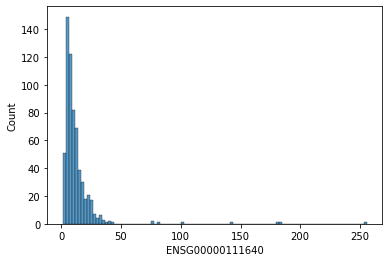

In [23]:
#Glyceraldehyde 3-phosphate dehydrogenase
gene_expression_dist('ENSG00000111640')

(                                           ENSG00000150991
 tissue         cell_type                                  
 UBERON:0002378 slow muscle cell                 161.947510
                fast muscle cell                  93.181671
 UBERON:0000970 corneal epithelial cell           71.685738
 UBERON:0002108 intestinal crypt stem cell        65.723389
 UBERON:0000964 corneal epithelial cell           57.167198
 ...                                                    ...
 UBERON:0008612 erythrocyte                             NaN
                mast cell                               NaN
                mature nk t cell                        NaN
 UBERON:0010032 schwann cell                            NaN
 UBERON:0010033 schwann cell                            NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000150991', ylabel='Count'>)

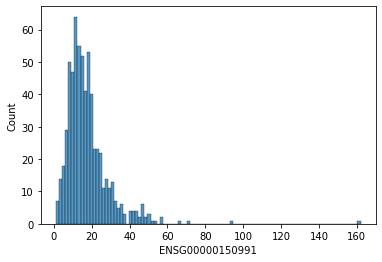

In [24]:
#Ubiquitin C
gene_expression_dist('ENSG00000150991')

(                                                              ENSG00000181222
 tissue         cell_type                                                     
 UBERON:0002190 neutrophil                                           17.217669
 UBERON:0000029 neutrophil                                           15.813733
 UBERON:0000059 intestinal crypt stem cell of large intestine        15.567108
 UBERON:0001911 endothelial cell of lymphatic vessel                 15.293393
 UBERON:0002106 neutrophil                                           15.176344
 ...                                                                       ...
 UBERON:0010032 schwann cell                                               NaN
                tongue muscle cell                                         NaN
 UBERON:0010033 endothelial cell of lymphatic vessel                       NaN
                schwann cell                                               NaN
                tongue muscle cell                  

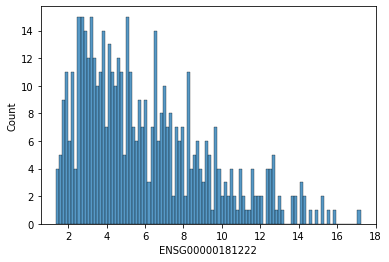

In [25]:
#RNA polymerase IIA
gene_expression_dist('ENSG00000181222')

(                                 ENSG00000075624
 tissue         cell_type                        
 UBERON:0002106 platelet               131.805283
 UBERON:0000178 platelet               106.908562
 UBERON:0003126 neutrophil              85.560898
 UBERON:0002371 cd24 neutrophil         82.335190
 UBERON:0000016 mast cell               79.327095
 ...                                          ...
 UBERON:0008612 fast muscle cell              NaN
                mature nk t cell              NaN
                slow muscle cell              NaN
 UBERON:0010032 schwann cell                  NaN
 UBERON:0010033 schwann cell                  NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000075624', ylabel='Count'>)

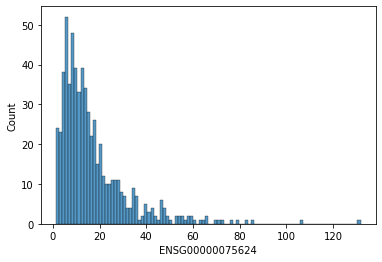

In [26]:
#Actin beta A
gene_expression_dist('ENSG00000075624')

## 10.3 Highly specifically expressed genes

(                                            ENSG00000254647
 tissue         cell_type                                   
 UBERON:0000016 pancreatic beta cell            22025.464844
                pancreatic pp cell              22025.464844
                t cell                          22025.464844
 UBERON:0000017 pancreatic beta cell            22025.464844
                pancreatic alpha cell           22025.464844
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>)

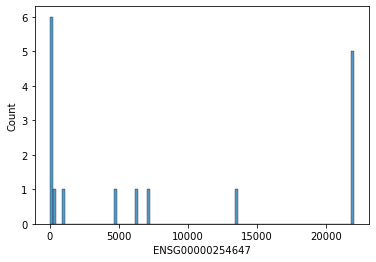

In [27]:
#Insulin (pancreatic beta cells)
gene_expression_dist('ENSG00000254647')

In [22]:
tabula_sapiens[tabula_sapiens['ENSG00000254647'] != np.nan]['ENSG00000254647'].loc[['UBERON:0000016', 'UBERON:0000017']]

tissue          cell_type               
UBERON:0000016  b cell                      13610.889648
                endothelial cell                     NaN
                mast cell                            NaN
                myeloid cell                         NaN
                pancreatic acinar cell               NaN
                pancreatic alpha cell                NaN
                pancreatic beta cell        22025.464844
                pancreatic ductal cell               NaN
                pancreatic pp cell          22025.464844
                pancreatic stellate cell             NaN
                t cell                      22025.464844
UBERON:0000017  b cell                        953.950073
                endothelial cell              321.301483
                fibroblast                   7142.053711
                mast cell                            NaN
                myeloid cell                  116.253189
                nk cell                      63

There are still cell types with high adjusted median expression of insulin which are not expected to have high expression of this gene.

(                                            ENSG00000168484
 tissue         cell_type                                   
 UBERON:0002048 type ii pneumocyte               1609.377197
                lung ciliated cell               1559.597656
                respiratory goblet cell          1426.608643
                basal cell                       1196.632202
                club cell                        1107.909912
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000168484', ylabel='Count'>)

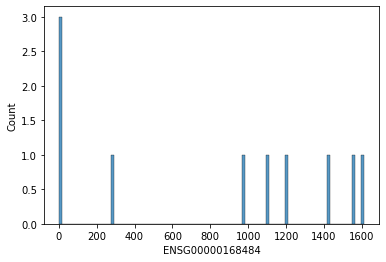

In [28]:
#Surfactant protein C (alveolar type II epithelial lung cells)
gene_expression_dist('ENSG00000168484')

(                                            ENSG00000243480
 tissue         cell_type                                   
 UBERON:0000016 pancreatic acinar cell          22025.464844
 UBERON:0000017 pancreatic acinar cell           5129.000977
                pancreatic ductal cell            166.294281
                t cell                            121.521805
 UBERON:0000016 endothelial cell                   42.099739
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000243480', ylabel='Count'>)

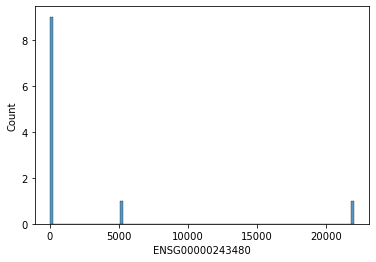

In [29]:
#Amylase 2B (pancreatic exocrine glandular cells)
gene_expression_dist('ENSG00000243480')

# 11. Lung gene expression distributions across cell types
## 11.1 Read in data and adjust function

In [30]:
lung = tabula_sapiens.loc['UBERON:0002048']
lung

ENSG00000227232  ENSG00000238009  \
cell_type                                                                  
adventitial cell                               2.304915              NaN   
alveolar fibroblast                                 NaN              NaN   
b cell                                              NaN              NaN   
basal cell                                     2.847742              NaN   
basophil                                            NaN              NaN   
bronchial smooth muscle cell                        NaN              NaN   
bronchial vessel endothelial cell                   NaN              NaN   
capillary aerocyte                                  NaN              NaN   
capillary endothelial cell                    10.658262              NaN   
cd4-positive alpha-beta t cell                      NaN              NaN   
cd4-positive, alpha-beta t cell                     NaN              NaN   
cd8-positive alpha-beta t cell                      NaN              NaN   
cd8-positive, alpha-beta t cell                     NaN              NaN   
classical monocyte                            38.448120              NaN   
club cell                                           NaN              NaN   
dendritic cell                                      NaN              NaN   
endothelial cell of artery                          NaN              NaN   
endothelial cell of lymphatic vessel                NaN              NaN   
fibroblast                                          NaN              NaN   
intermediate monocyte                               NaN              NaN   
lung ciliated cell                                  NaN              NaN   
lung microvascular endothelial cell                 NaN              NaN   
macrophage                                     7.065258     11645.761719   
mesothelial cell                                    NaN              NaN   
myofibroblast cell                                  NaN              NaN   
neutrophil                                          NaN              NaN   
nk cell                                             NaN              NaN   
non-classical monocyte                              NaN              NaN   
pericyte cell                                       NaN              NaN   
plasma cell                                         NaN              NaN   
plasmacytoid dendritic cell                         NaN              NaN   
pulmonary ionocyte                                  NaN              NaN   
respiratory goblet cell                             NaN              NaN   
respiratory mucous cell                             NaN              NaN   
serous cell of epithelium of bronchus               NaN              NaN   
smooth muscle cell                                  NaN              NaN   
type i pneumocyte                                   NaN              NaN   
type ii pneumocyte                             2.934693       305.737885   
vascular associated smooth muscle cell              NaN              NaN   
vein endothelial cell                               NaN              NaN   

                                        ENSG00000233750  ENSG00000268903  \
cell_type                                                                  
adventitial cell                                    NaN              NaN   
alveolar fibroblast                                 NaN              NaN   
b cell                                              NaN              NaN   
basal cell                                          NaN              NaN   
basophil                                            NaN              NaN   
bronchial smooth muscle cell                        NaN              NaN   
bronchial vessel endothelial cell                   NaN              NaN   
capillary aerocyte                                  NaN              NaN   
capillary endothelial cell                          NaN              NaN   
cd4-positiv

In [31]:
def gene_expression_dist(gene):
    
    gene_df = pd.DataFrame(lung[gene])
    
    ax = sns.histplot(data = gene_df, x = gene, bins = 100)
    
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), ax

## 11.2 Housekeeping genes

(                                        ENSG00000111640
 cell_type                                              
 bronchial vessel endothelial cell             19.245228
 classical monocyte                            17.675255
 smooth muscle cell                            15.927636
 pulmonary ionocyte                            14.246191
 lung microvascular endothelial cell           13.573997
 dendritic cell                                12.763678
 capillary aerocyte                            12.491606
 intermediate monocyte                         11.164561
 adventitial cell                              10.503680
 basal cell                                    10.035592
 bronchial smooth muscle cell                   9.807484
 vein endothelial cell                          9.326166
 cd8-positive, alpha-beta t cell                9.136560
 mesothelial cell                               8.735196
 cd4-positive alpha-beta t cell                 8.669743
 endothelial cell of artery    

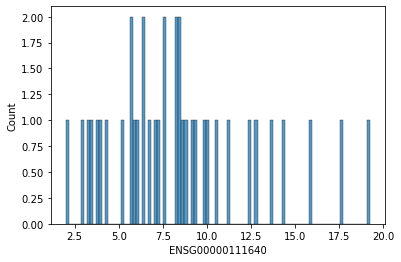

In [32]:
#Glyceraldehyde 3-phosphate dehydrogenase
gene_expression_dist('ENSG00000111640')

(                                        ENSG00000150991
 cell_type                                              
 adventitial cell                              44.837044
 fibroblast                                    31.610472
 type i pneumocyte                             31.123575
 alveolar fibroblast                           27.277084
 capillary aerocyte                            25.045265
 endothelial cell of artery                    24.413479
 bronchial smooth muscle cell                  22.788437
 vascular associated smooth muscle cell        20.475605
 basal cell                                    19.630524
 capillary endothelial cell                    19.463711
 pulmonary ionocyte                            19.415474
 vein endothelial cell                         18.904091
 mesothelial cell                              18.516920
 type ii pneumocyte                            18.387094
 pericyte cell                                 18.264965
 myofibroblast cell            

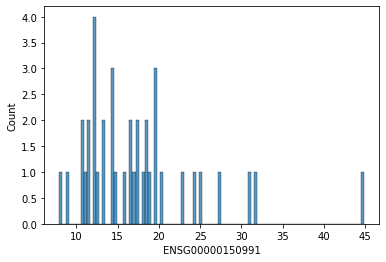

In [33]:
#Ubiquitin C
gene_expression_dist('ENSG00000150991')

(                                        ENSG00000181222
 cell_type                                              
 neutrophil                                    13.249931
 nk cell                                       12.878853
 pericyte cell                                 12.628704
 capillary aerocyte                            12.611242
 cd8-positive, alpha-beta t cell               12.072327
 capillary endothelial cell                    11.518784
 cd4-positive, alpha-beta t cell               10.989986
 vascular associated smooth muscle cell        10.082249
 b cell                                         9.643183
 cd4-positive alpha-beta t cell                 9.486761
 cd8-positive alpha-beta t cell                 9.353364
 basophil                                       8.677031
 alveolar fibroblast                            8.312866
 bronchial smooth muscle cell                   7.997874
 classical monocyte                             7.368236
 vein endothelial cell         

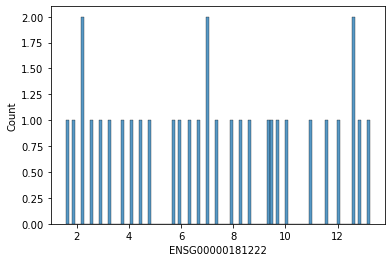

In [34]:
#RNA polymerase IIA
gene_expression_dist('ENSG00000181222')

(                                        ENSG00000075624
 cell_type                                              
 bronchial smooth muscle cell                  46.558437
 neutrophil                                    44.844730
 classical monocyte                            42.390030
 intermediate monocyte                         38.525909
 vascular associated smooth muscle cell        35.567211
 smooth muscle cell                            35.377079
 dendritic cell                                35.152149
 adventitial cell                              35.092106
 non-classical monocyte                        28.675625
 pericyte cell                                 26.870327
 type i pneumocyte                             26.656246
 fibroblast                                    26.557892
 cd8-positive, alpha-beta t cell               26.549580
 nk cell                                       23.267811
 capillary endothelial cell                    21.849220
 endothelial cell of artery    

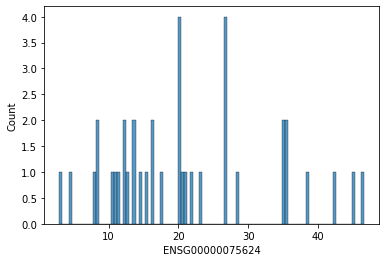

In [35]:
#Actin beta A
gene_expression_dist('ENSG00000075624')

## 12.3 Highly specifically expressed genes

(                                        ENSG00000254647
 cell_type                                              
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basal cell                                          NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte                                  NaN
 capillary endothelial cell                          NaN
 cd4-positive alpha-beta t cell                      NaN
 cd4-positive, alpha-beta t cell                     NaN
 cd8-positive alpha-beta t cell                      NaN
 cd8-positive, alpha-beta t cell                     NaN
 classical monocyte                                  NaN
 club cell                                           NaN
 dendritic cell                

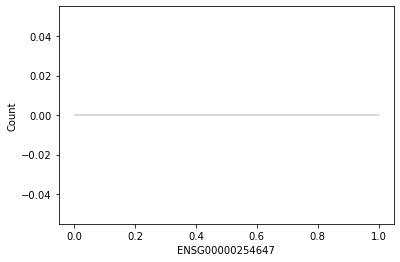

In [36]:
#Insulin (pancreatic beta cells)
gene_expression_dist('ENSG00000254647')

(                                        ENSG00000168484
 cell_type                                              
 type ii pneumocyte                          1609.377197
 lung ciliated cell                          1559.597656
 respiratory goblet cell                     1426.608643
 basal cell                                  1196.632202
 club cell                                   1107.909912
 type i pneumocyte                            975.768188
 macrophage                                   292.158844
 neutrophil                                     4.286518
 plasma cell                                    3.663638
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte            

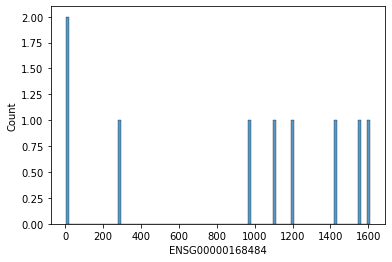

In [37]:
#Surfactant protein C (alveolar type II epithelial lung cells)
gene_expression_dist('ENSG00000168484')

(                                        ENSG00000243480
 cell_type                                              
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basal cell                                          NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte                                  NaN
 capillary endothelial cell                          NaN
 cd4-positive alpha-beta t cell                      NaN
 cd4-positive, alpha-beta t cell                     NaN
 cd8-positive alpha-beta t cell                      NaN
 cd8-positive, alpha-beta t cell                     NaN
 classical monocyte                                  NaN
 club cell                                           NaN
 dendritic cell                

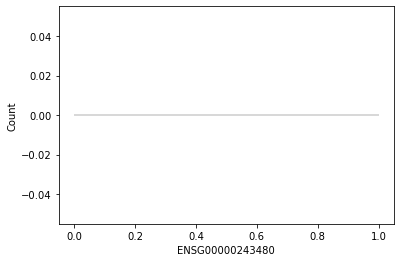

In [38]:
#Amylase 2B (pancreatic exocrine glandular cells)
gene_expression_dist('ENSG00000243480')

These distributions look good and suggest our new metric has worked to eliminate erroneous high expressions in incorrect cell types since there is no median expression of insulin or amylase in any cell type from the lung which there was in the previous case before we applied the average_metric function.

# 13. Gene distributions across prostate cells

In [2]:
all_cells = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [3]:
prostate = all_cells[all_cells.tissue == 'UBERON:0002367']

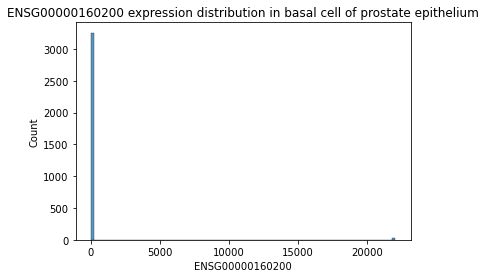

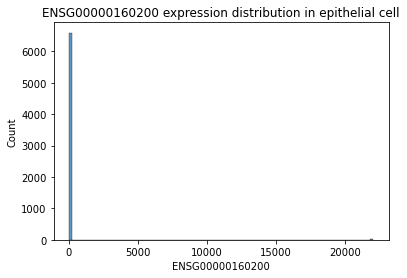

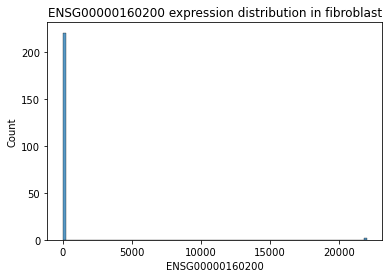

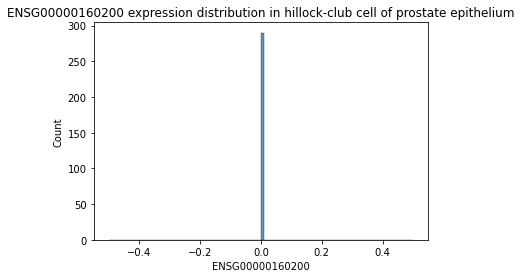

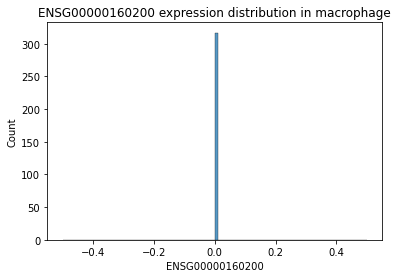

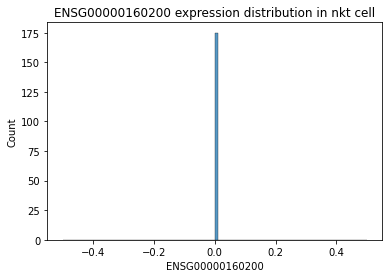

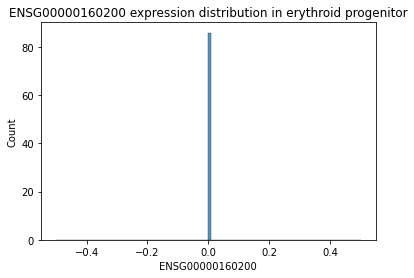

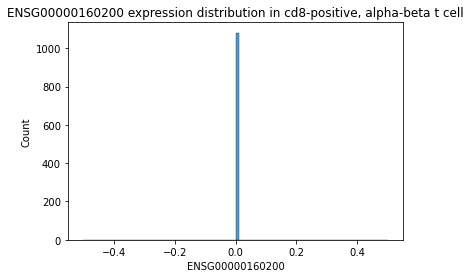

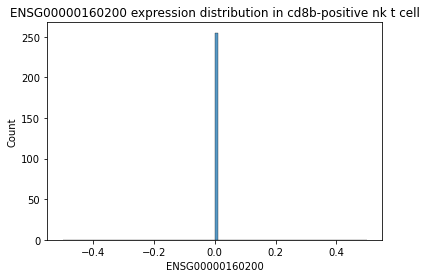

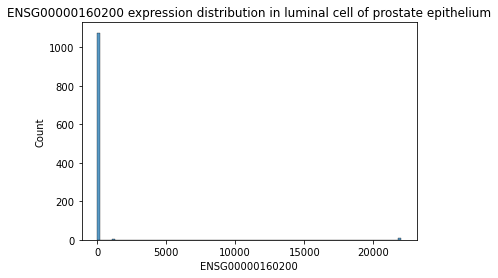

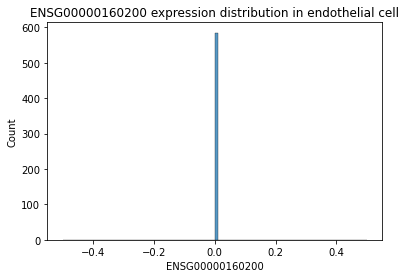

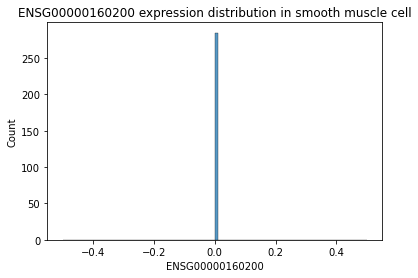

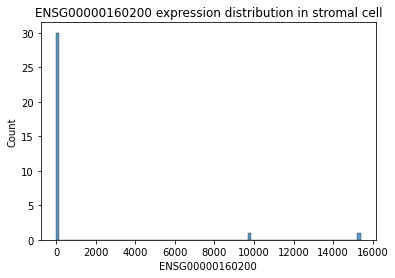

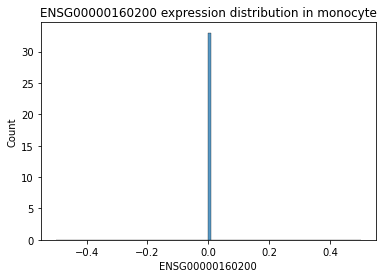

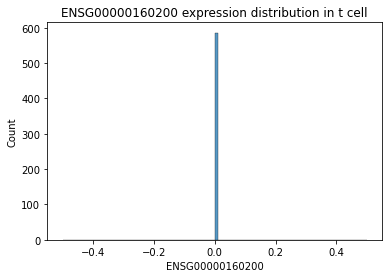

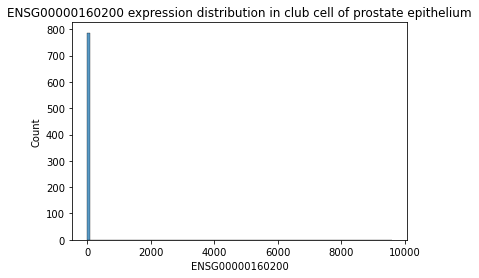

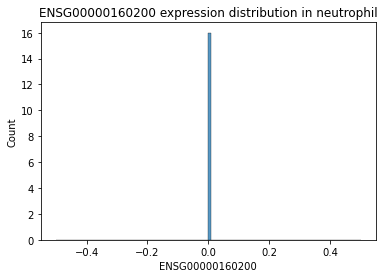

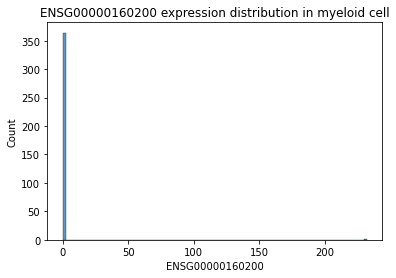

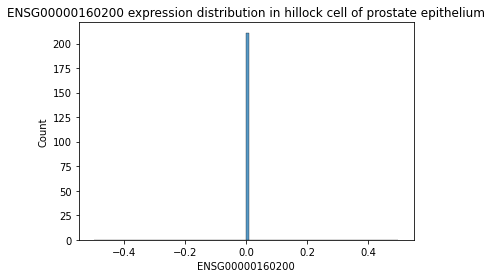

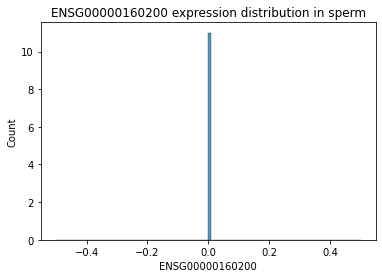

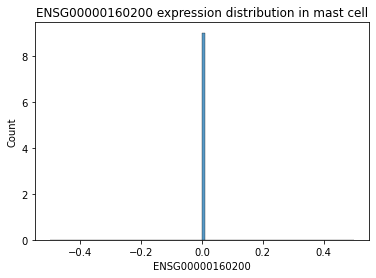

In [68]:
#ENSG00000160200
for i in prostate.cell_type.unique():
    ax = sns.histplot(data = prostate[prostate.cell_type == i], x = 'ENSG00000160200', bins = 100)
    plt.title(f'ENSG00000160200 expression distribution in {i}')
    plt.show()

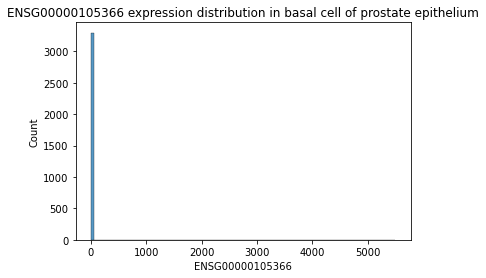

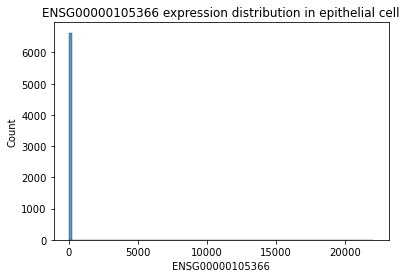

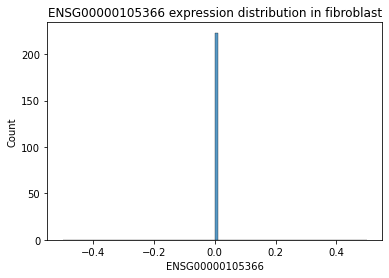

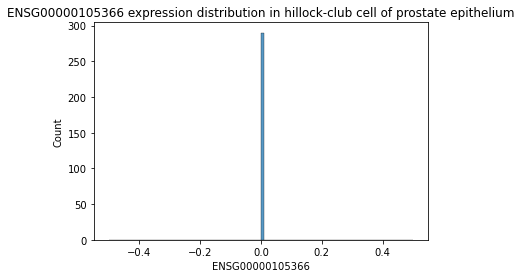

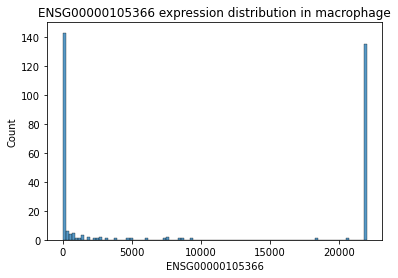

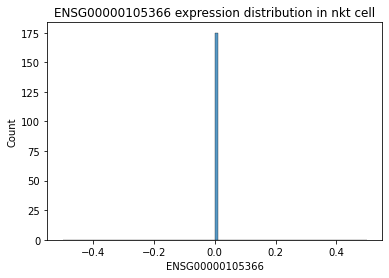

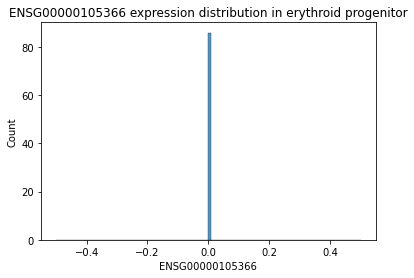

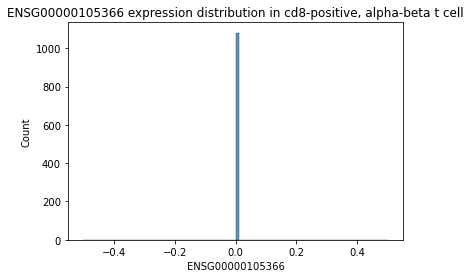

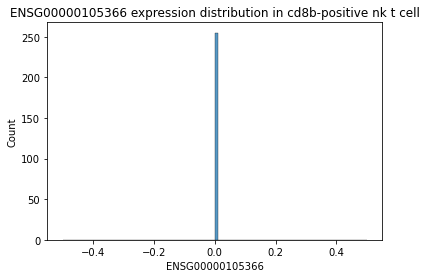

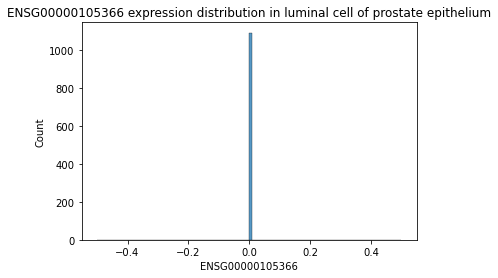

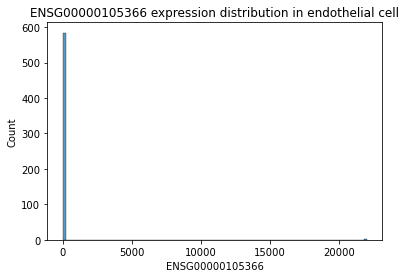

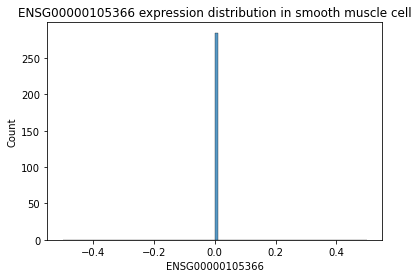

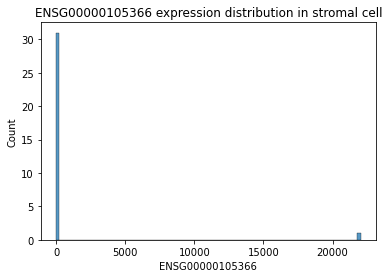

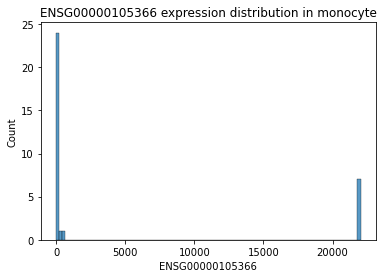

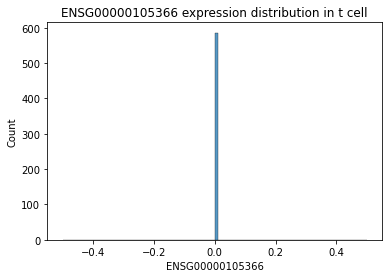

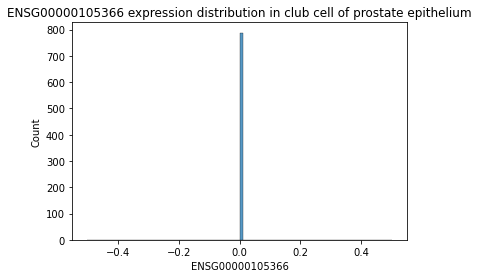

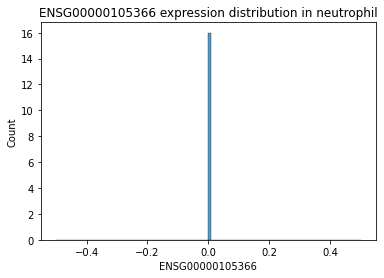

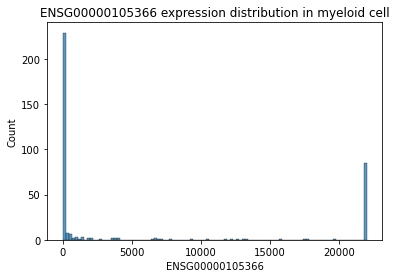

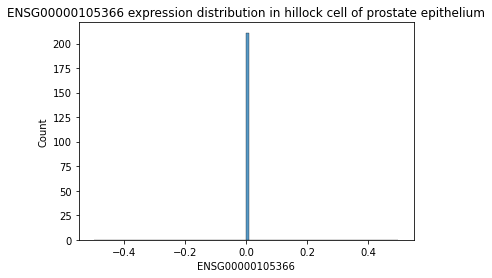

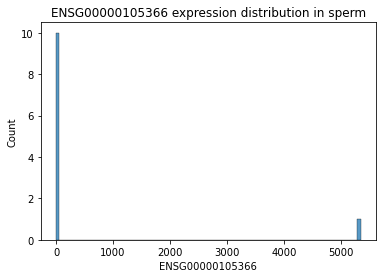

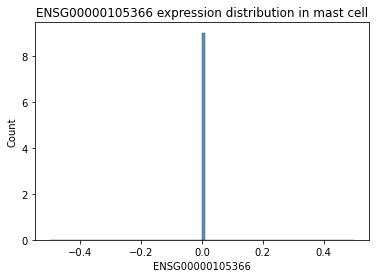

In [70]:
#ENSG00000105366
for i in prostate.cell_type.unique():
    ax = sns.histplot(data = prostate[prostate.cell_type == i], x = 'ENSG00000105366', bins = 100)
    plt.title(f'ENSG00000105366 expression distribution in {i}')
    plt.show()

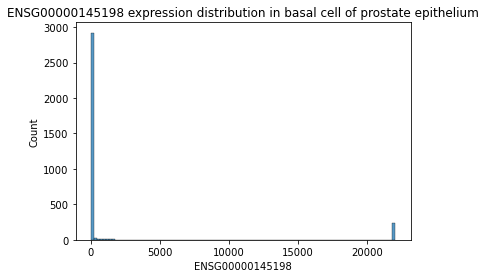

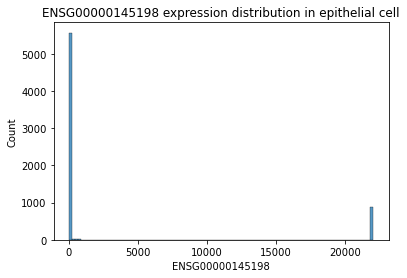

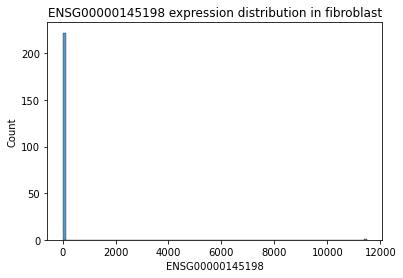

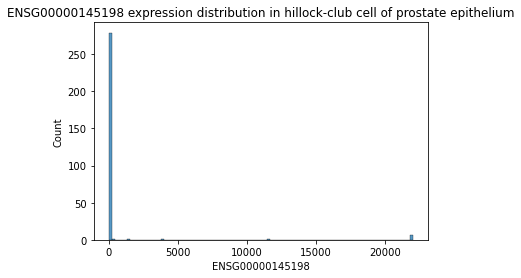

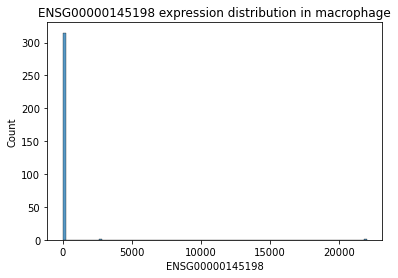

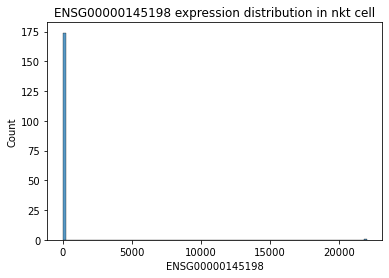

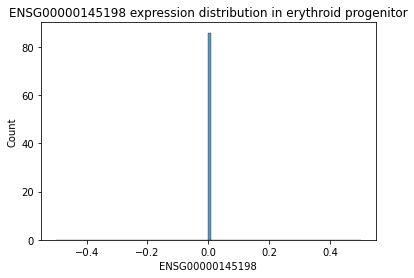

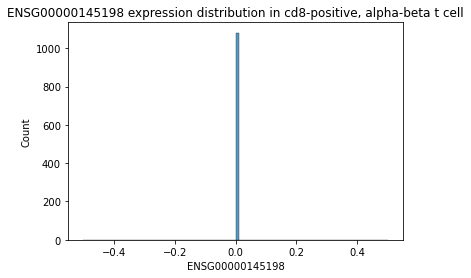

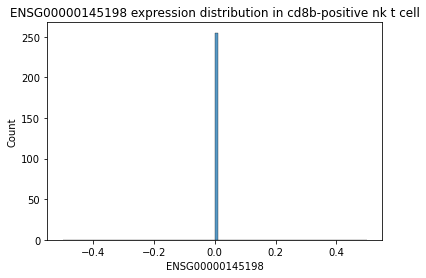

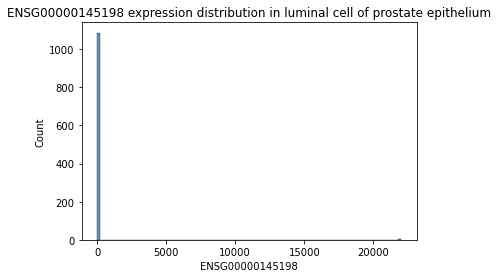

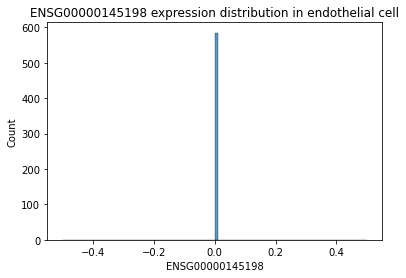

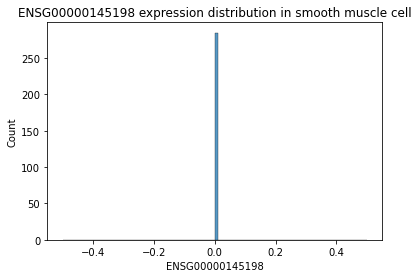

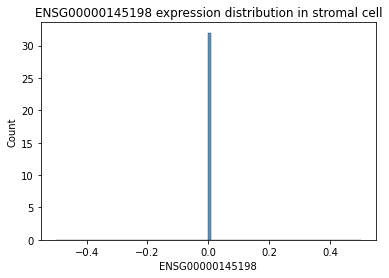

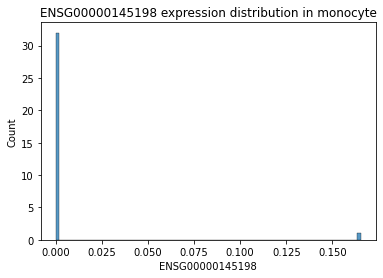

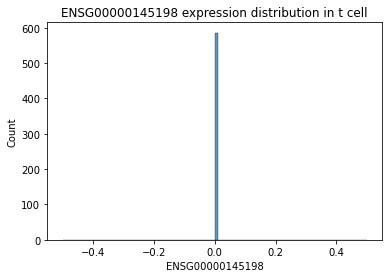

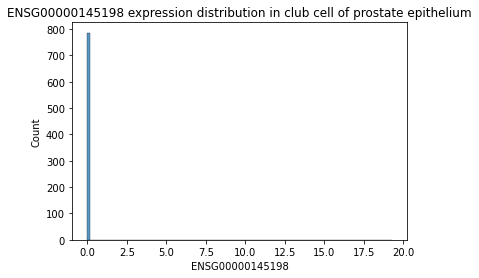

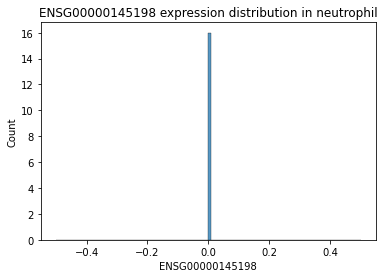

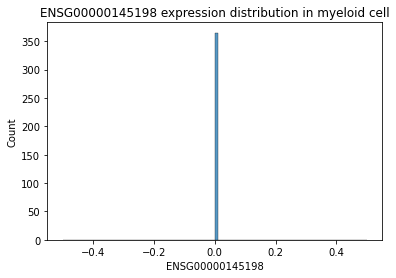

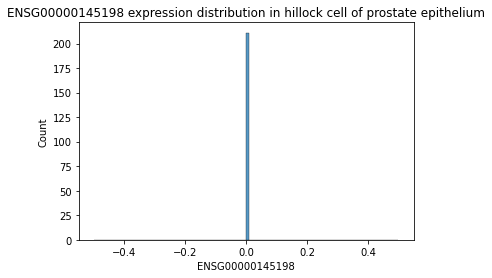

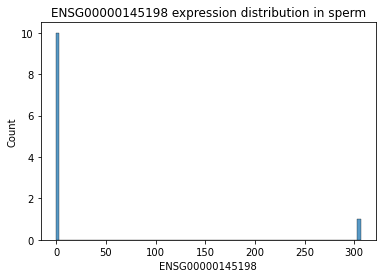

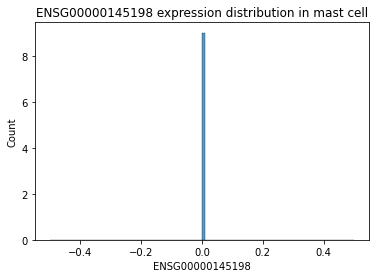

In [71]:
#ENSG00000145198
for i in prostate.cell_type.unique():
    ax = sns.histplot(data = prostate[prostate.cell_type == i], x = 'ENSG00000145198', bins = 100)
    plt.title(f'ENSG00000145198 expression distribution in {i}')
    plt.show()

### Log-scaled axis

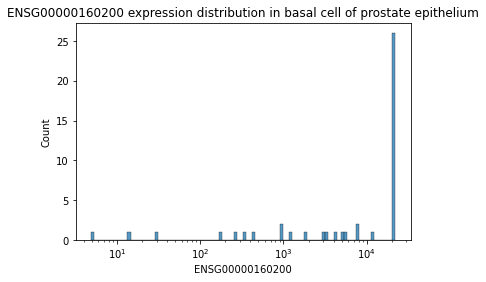

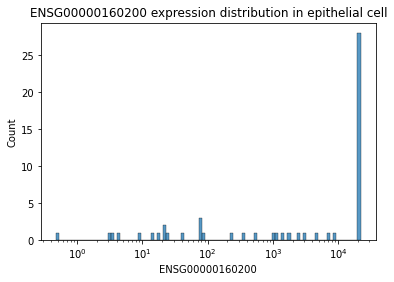

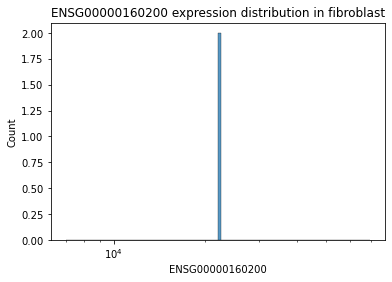

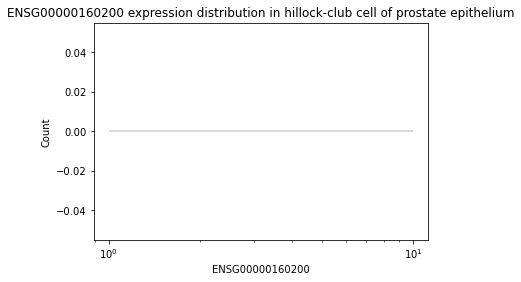

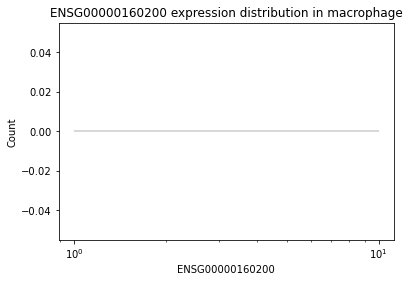

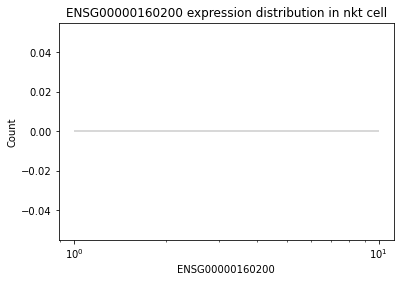

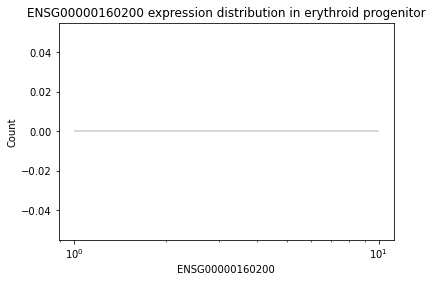

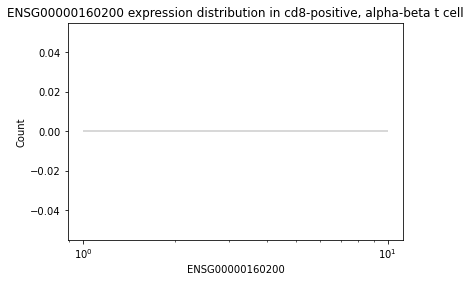

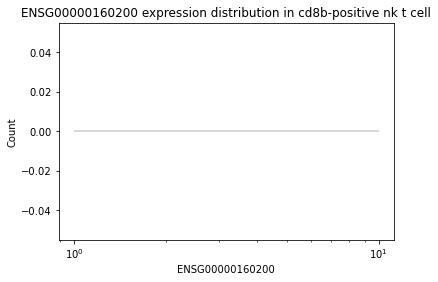

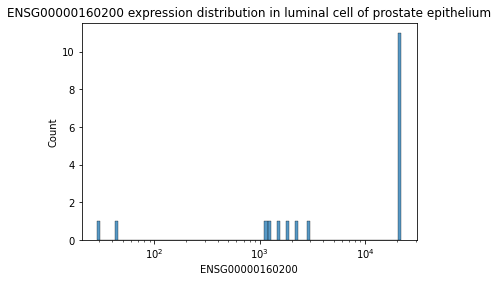

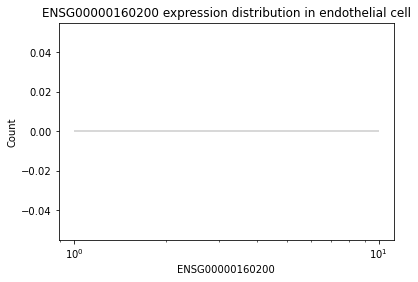

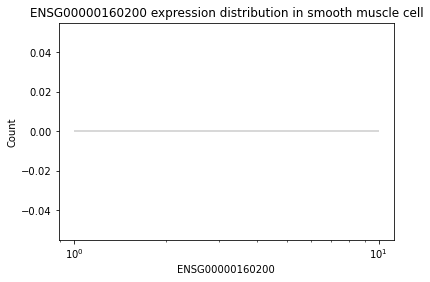

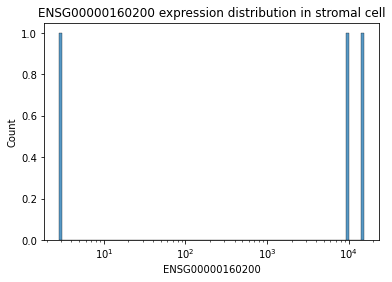

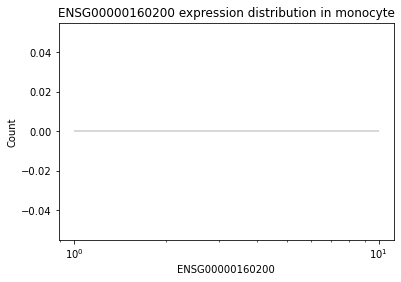

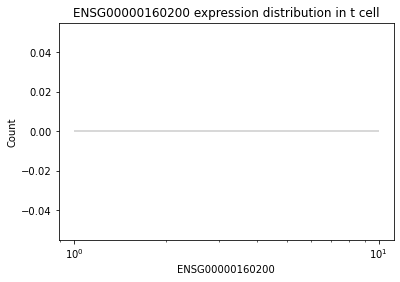

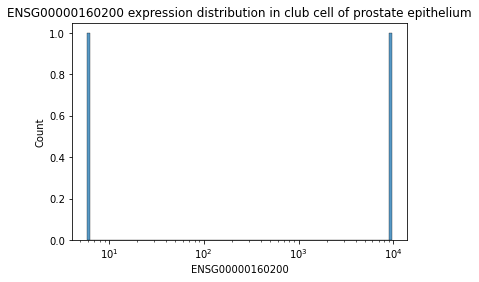

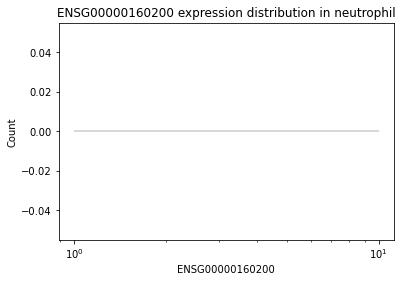

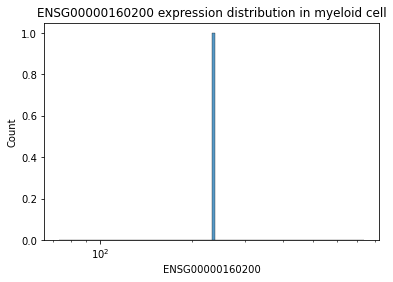

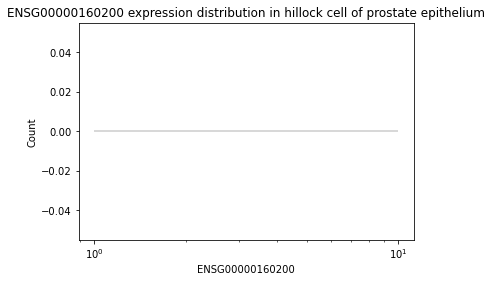

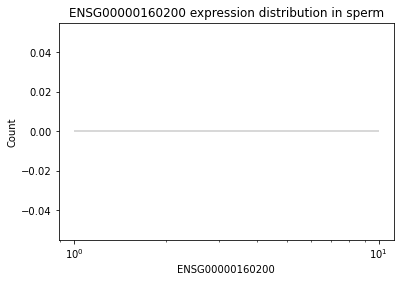

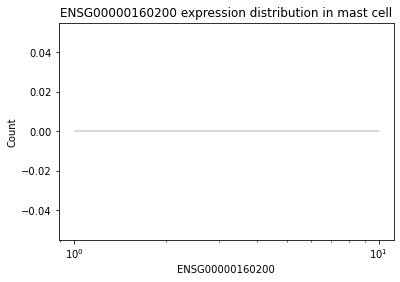

In [4]:
#ENSG00000160200
for i in prostate.cell_type.unique():
    ax = sns.histplot(data = prostate[prostate.cell_type == i], x = 'ENSG00000160200', bins = 100, log_scale = True)
    plt.title(f'ENSG00000160200 expression distribution in {i}')
    plt.show()

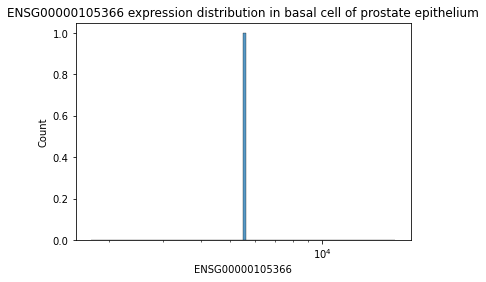

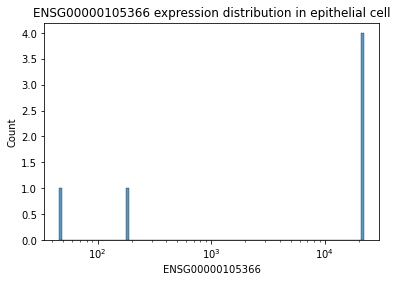

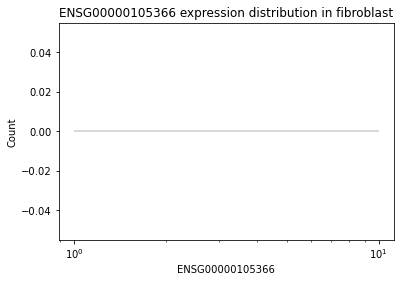

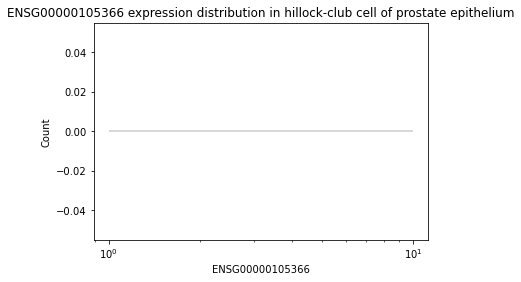

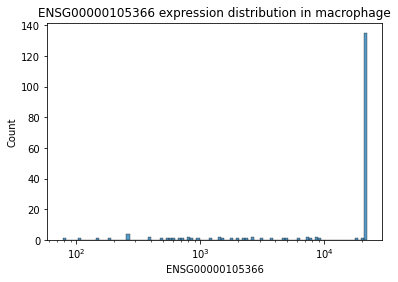

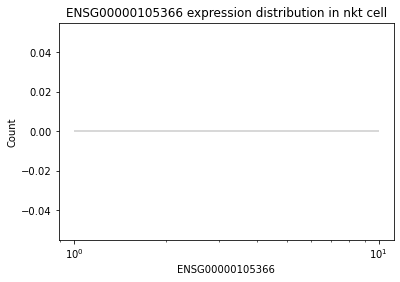

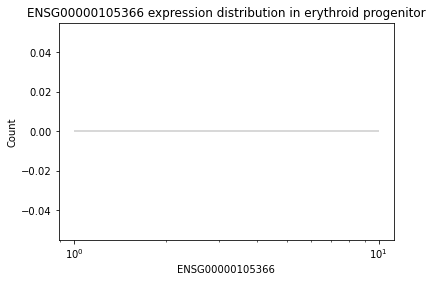

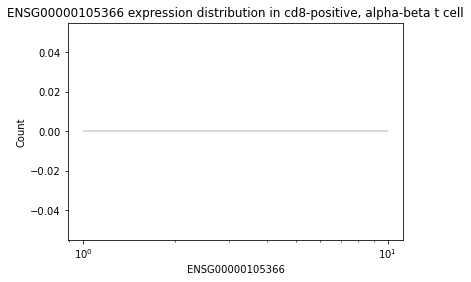

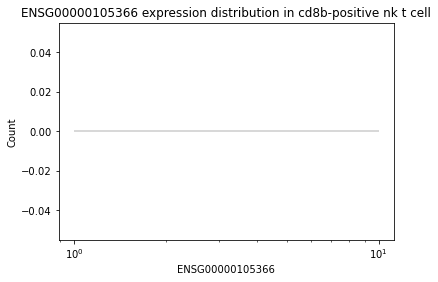

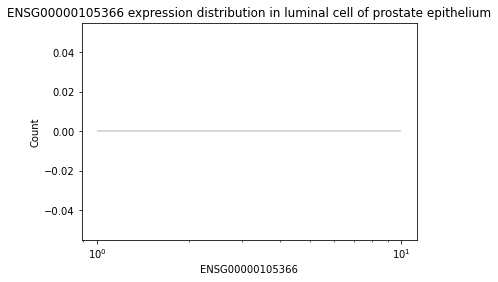

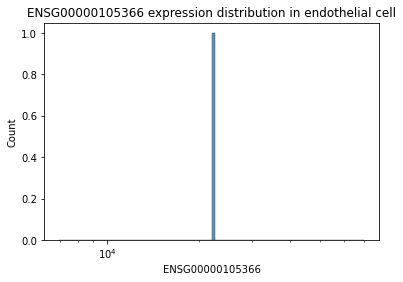

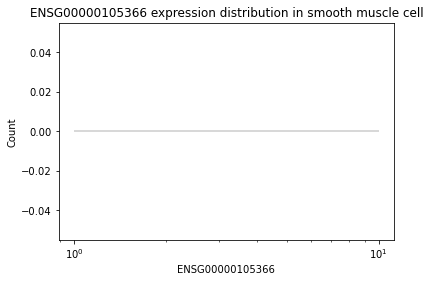

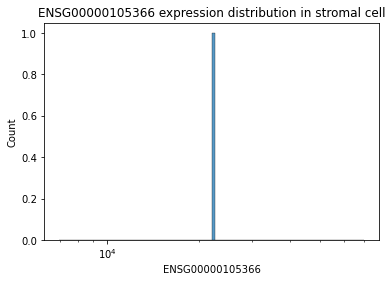

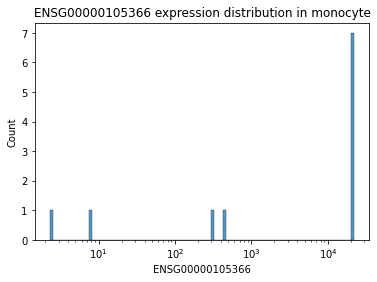

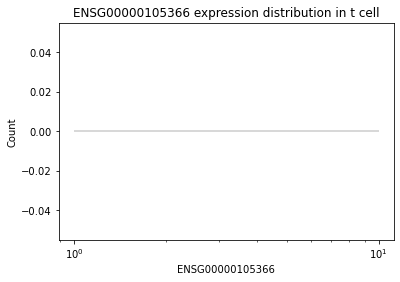

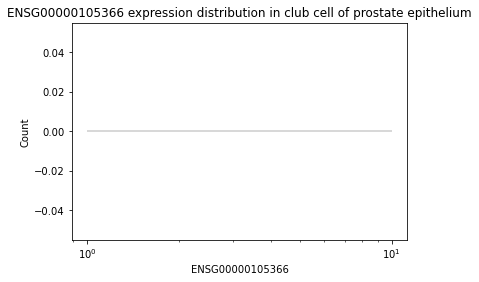

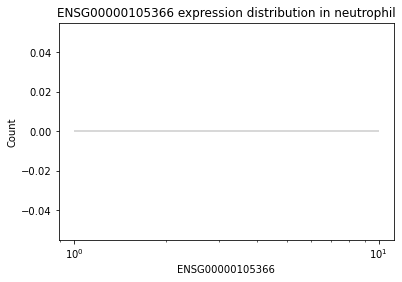

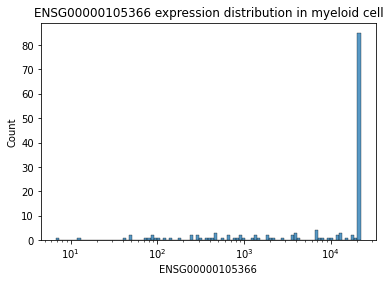

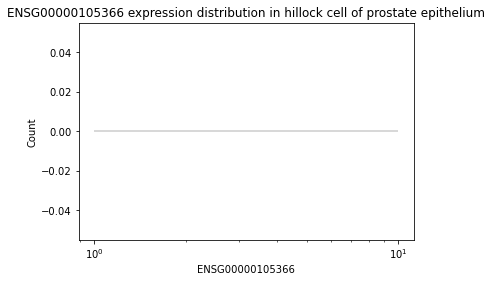

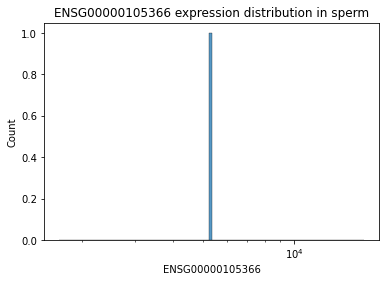

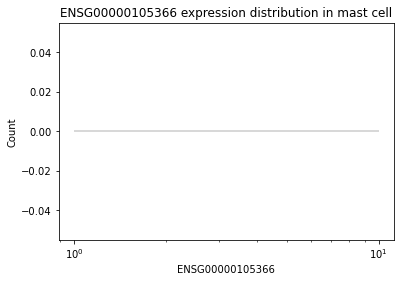

In [5]:
#ENSG00000105366
for i in prostate.cell_type.unique():
    ax = sns.histplot(data = prostate[prostate.cell_type == i], x = 'ENSG00000105366', bins = 100, log_scale = True)
    plt.title(f'ENSG00000105366 expression distribution in {i}')
    plt.show()

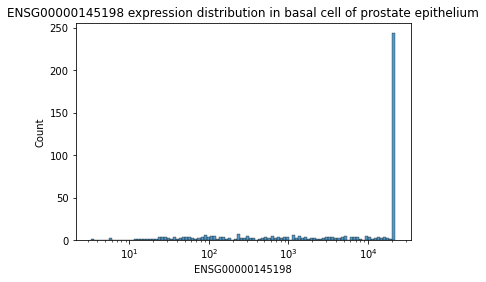

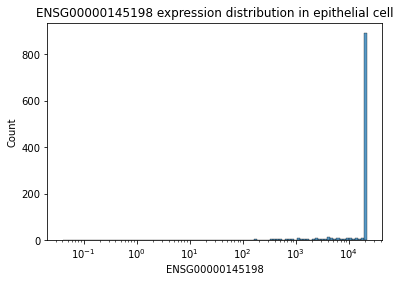

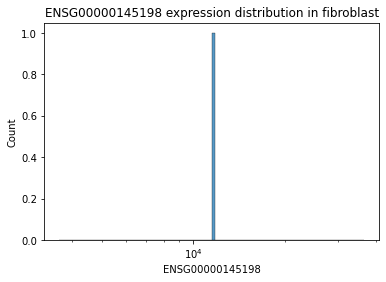

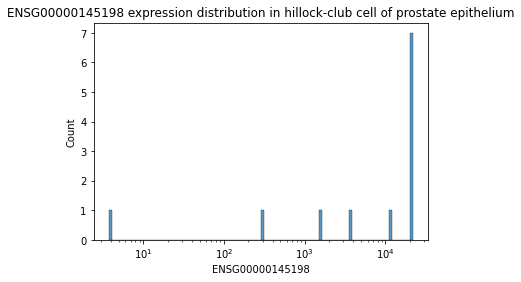

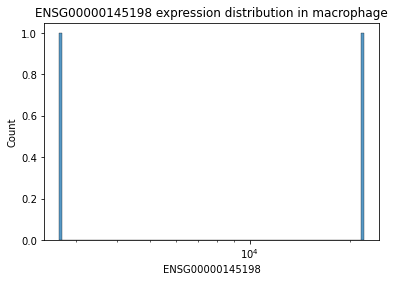

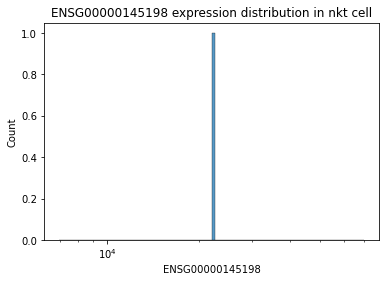

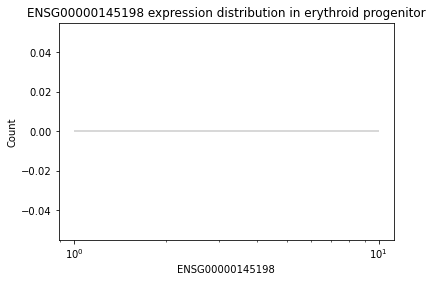

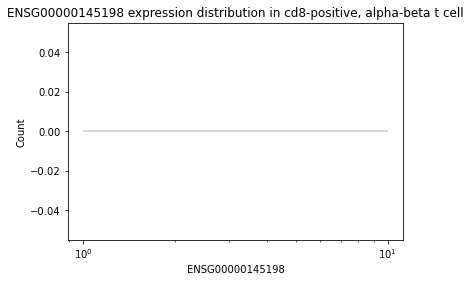

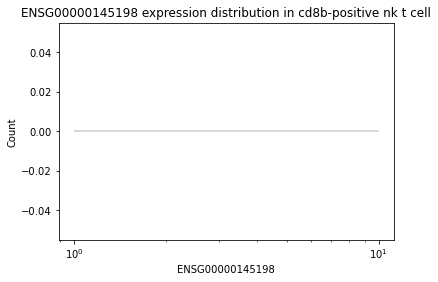

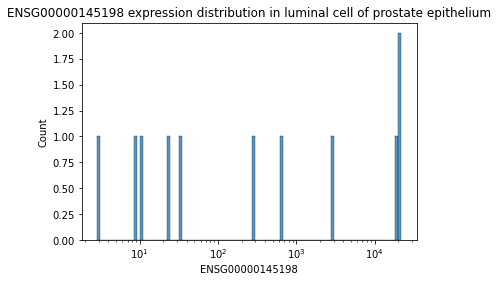

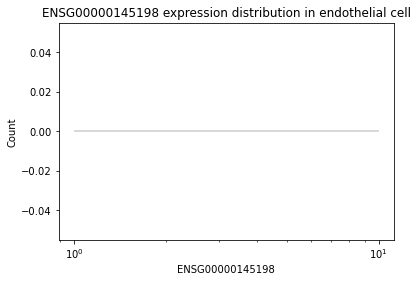

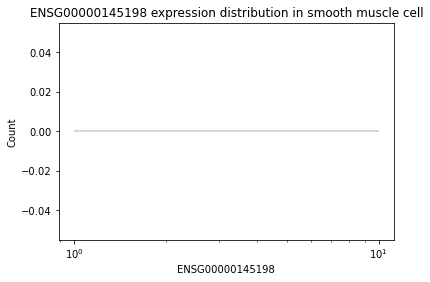

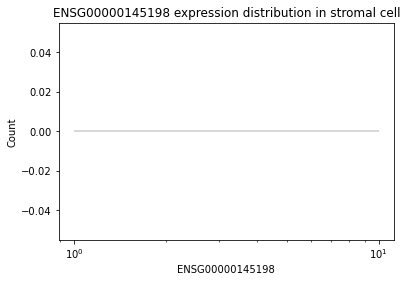

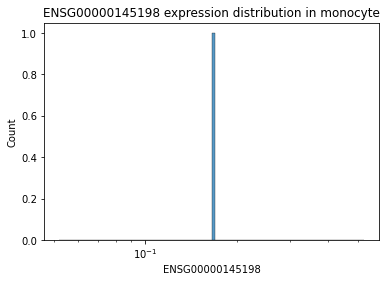

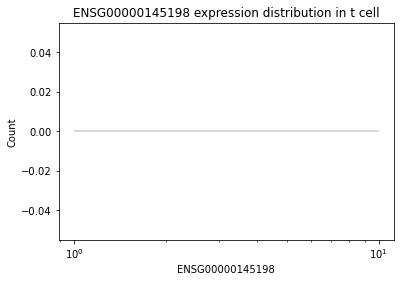

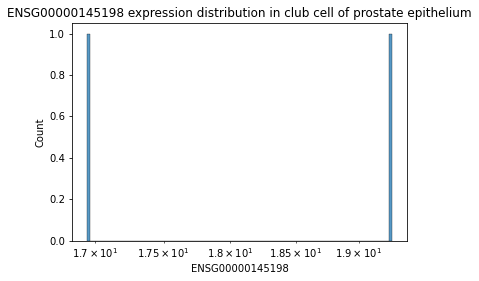

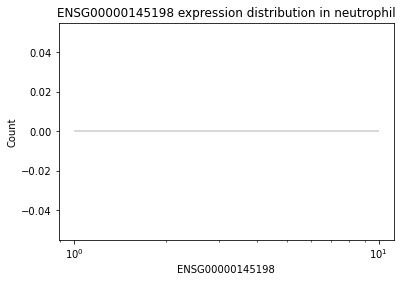

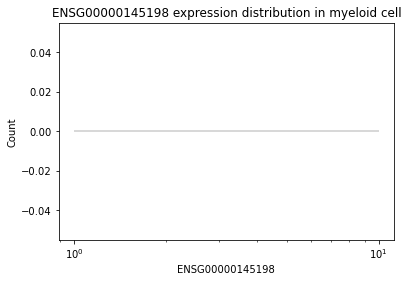

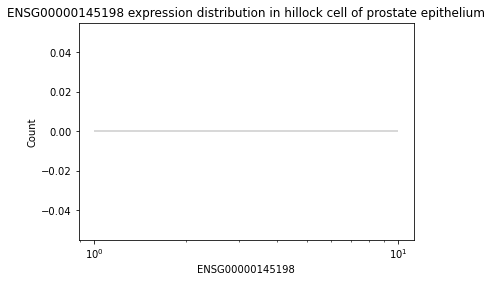

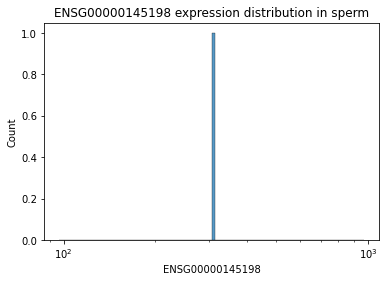

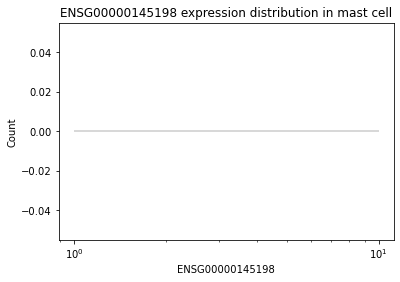

In [6]:
#ENSG00000145198
for i in prostate.cell_type.unique():
    ax = sns.histplot(data = prostate[prostate.cell_type == i], x = 'ENSG00000145198', bins = 100, log_scale = True)
    plt.title(f'ENSG00000145198 expression distribution in {i}')
    plt.show()